In [1]:
import math
import json
import numpy as np 
import sub_func_ce
from sub_func_ce import abs_dis, find_overlap
import matplotlib.pyplot as plt
from itertools import combinations, permutations, product
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LassoLarsIC
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RationalQuadratic, Matern
from sklearn import mixture
from random import randrange
from IPython.display import clear_output
import os
from matplotlib import cm
import pickle
from msad_ana import msad_ana_qua

from torch.nn.utils import clip_grad_norm_
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter

# %matplotlib widget
%matplotlib inline

def normal_dist(x, mu, std):
    prob_density = (np.pi*std) * np.exp(-0.5*((x-mu)/std)**2)
    return prob_density
    
def draw_3d(ind_raw):
    ind_raw = np.array(ind_raw)
    plt.rcParams["figure.figsize"] = [5, 5]
    # plt.rcParams["figure.autolayout"] = True
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(ind_raw[:,0], ind_raw[:,1], ind_raw[:,2], alpha = 0.5, c = 'r')
    plt.show()

def ele_list_gen(cr_c, mn_c, co_c, ni_c, num_c, mode = 'randchoice'):
    np.random.seed()

    assert abs(cr_c + mn_c + co_c + ni_c - 1) < 0.001, 'Make sure atomic ratio sum to 1'

    while True:
        if mode == 'randchoice':
            len_cr = randrange(int(cr_c*num_c),int(cr_c*num_c)+2)
            len_mn = randrange(int(mn_c*num_c),int(mn_c*num_c)+2)
            len_co = randrange(int(co_c*num_c),int(co_c*num_c)+2)
        elif mode == 'int':
            len_cr = int(cr_c*num_c)
            len_mn = int(mn_c*num_c)
            len_co = int(co_c*num_c)
        
        len_ni = num_c-len_cr-len_mn-len_co
        if (abs(len_ni-num_c*ni_c) <= 1
            and abs(len_cr-num_c*cr_c) <= 1
            and abs(len_mn-num_c*mn_c) <= 1
            and abs(len_co-num_c*co_c) <= 1):
            break

    ele_list_raw = np.concatenate([np.zeros(len_cr)+2,np.ones(len_mn),0-np.ones(len_co),-1-np.ones(len_ni)],axis=0)
    np.random.shuffle(ele_list_raw)
    
    return ele_list_raw

def swap_step(action, state,):

    a1 = action[0]
    a2 = action[1]

    state[a2], state[a1] = state[a1], state[a2]

    return state

def create_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        print("Created Directory : ", directory)
    else:
        print("Directory already existed : ", directory)
    return directory

class CE:
    def __init__(self, 
        ind_1nn, ind_2nn, ind_3nn, ind_4nn, 
        ind_5nn, ind_6nn, ind_qua1nn, ind_qua1nn2nn,
        ind_qua111122,

        ind_trip111, ind_trip112, ind_trip113, ind_trip114,
        ind_trip123, ind_trip125, ind_trip133, ind_trip134, 
        ind_trip135, ind_trip145, ind_trip155, ind_trip224,
        ind_trip233, ind_trip255, ind_trip334, ind_trip335, 
        ind_trip345, ind_trip444, ind_trip455, 

        ind_1nn_pbc, ind_2nn_pbc, ind_3nn_pbc, ind_4nn_pbc, 
        ind_5nn_pbc, ind_6nn_pbc, ind_qua1nn_pbc, ind_qua1nn2nn_pbc, 
        ind_qua111122_pbc,

        ind_trip111_pbc, ind_trip112_pbc, ind_trip113_pbc, ind_trip114_pbc,
        ind_trip123_pbc, ind_trip125_pbc, ind_trip133_pbc, ind_trip134_pbc, 
        ind_trip135_pbc, ind_trip145_pbc, ind_trip155_pbc, ind_trip224_pbc,
        ind_trip233_pbc, ind_trip255_pbc, ind_trip334_pbc, ind_trip335_pbc, 
        ind_trip345_pbc, ind_trip444_pbc, ind_trip455_pbc, 
        #* 21 quadruplets
        qua_indlist_raw, qua_indlist_pbc, 

        ind_raw, use_pbc):

        #* Inner of 32-atom config.
        self.ind_1nn = ind_1nn
        self.ind_2nn = ind_2nn
        self.ind_3nn = ind_3nn
        self.ind_4nn = ind_4nn
        self.ind_5nn = ind_5nn
        self.ind_6nn = ind_6nn
        self.ind_qua1nn = ind_qua1nn
        self.ind_qua1nn2nn = ind_qua1nn2nn
        self.ind_qua111122 = ind_qua111122

        #* Cluster on boundary of primary config.
        self.ind_1nn_pbc = ind_1nn_pbc
        self.ind_2nn_pbc = ind_2nn_pbc
        self.ind_3nn_pbc = ind_3nn_pbc
        self.ind_4nn_pbc = ind_4nn_pbc
        self.ind_5nn_pbc = ind_5nn_pbc
        self.ind_6nn_pbc = ind_6nn_pbc
        self.ind_qua1nn_pbc = ind_qua1nn_pbc
        self.ind_qua1nn2nn_pbc = ind_qua1nn2nn_pbc
        self.ind_qua111122_pbc = ind_qua111122_pbc

        #* Triplets.
        self.ind_trip111, self.ind_trip111_pbc = ind_trip111, ind_trip111_pbc 
        self.ind_trip112, self.ind_trip112_pbc = ind_trip112, ind_trip112_pbc 
        self.ind_trip113, self.ind_trip113_pbc = ind_trip113, ind_trip113_pbc 
        self.ind_trip114, self.ind_trip114_pbc = ind_trip114, ind_trip114_pbc 
        self.ind_trip123, self.ind_trip123_pbc = ind_trip123, ind_trip123_pbc 
        self.ind_trip125, self.ind_trip125_pbc = ind_trip125, ind_trip125_pbc 
        self.ind_trip133, self.ind_trip133_pbc = ind_trip133, ind_trip133_pbc 
        self.ind_trip134, self.ind_trip134_pbc = ind_trip134, ind_trip134_pbc 
        self.ind_trip135, self.ind_trip135_pbc = ind_trip135, ind_trip135_pbc 
        self.ind_trip145, self.ind_trip145_pbc = ind_trip145, ind_trip145_pbc 
        self.ind_trip155, self.ind_trip155_pbc = ind_trip155, ind_trip155_pbc 
        self.ind_trip224, self.ind_trip224_pbc = ind_trip224, ind_trip224_pbc 
        self.ind_trip233, self.ind_trip233_pbc = ind_trip233, ind_trip233_pbc 
        self.ind_trip255, self.ind_trip255_pbc = ind_trip255, ind_trip255_pbc 
        self.ind_trip334, self.ind_trip334_pbc = ind_trip334, ind_trip334_pbc 
        self.ind_trip335, self.ind_trip335_pbc = ind_trip335, ind_trip335_pbc 
        self.ind_trip345, self.ind_trip345_pbc = ind_trip345, ind_trip345_pbc 
        self.ind_trip444, self.ind_trip444_pbc = ind_trip444, ind_trip444_pbc
        self.ind_trip455, self.ind_trip455_pbc = ind_trip455, ind_trip455_pbc

        #* Quadruplets
        self.qua_indlist_raw, self.qua_indlist_pbc = qua_indlist_raw, qua_indlist_pbc

        self.ind_raw = ind_raw
        self.use_pbc = use_pbc

        self.sym_oplist = np.array([2, 1, 1, 0, 6, 0, 4, 12, 24])
        self.sym_optri = np.array([6, 3, 1])
        self.sym_opqua = np.array([0, 0, 1, 0, 0, 0, 2, 0, 4])

        '''Create list of all possible combination of embedded atoms
        on clusters'''
        pair_comb, tri_comb, qua_comb = [], [], []
        for i, j, k, l in product([-2,-1,1,2], repeat=4):
            pair_comb.append([i,j])
            tri_comb.append([i,j,k])
            qua_comb.append([i,j,k,l])

        self.pair_comb = np.unique(pair_comb, axis=0)
        self.tri_comb = np.unique(tri_comb, axis=0)
        self.qua_comb = np.array(qua_comb)

    #*Normalizaiton by the symmetry operation for each cluster
    def sym_operator(self, cluster, mode='None'):
        if mode == 'None':
            mode_cluster = len(cluster)
            uni, count_uni = np.unique(cluster, return_counts=True)
            len_uni = len(uni)
            count_uni = np.sort(count_uni)
            mode_sym = mode_cluster - len(uni)
            sym_op = self.sym_oplist[mode_sym+mode_cluster-2]

        elif mode == 'tri1nn':
            mode_cluster = len(cluster)
            uni, count_uni = np.unique(cluster, return_counts=True)
            len_uni = len(uni)
            mode_sym = mode_cluster - len(uni)
            sym_op = self.sym_optri[mode_sym]
        
        elif mode == 'qua1nn': #* 111111
            uni, count_uni = np.unique(cluster, return_counts=True)
            len_uni = len(uni)
            count_uni = np.sort(count_uni)
            len_count = len(count_uni)
            c_ind = len_uni+len_count+count_uni[-1]-count_uni[0]
            sym_op = self.sym_oplist[c_ind]

        elif mode == 'qua1nn2nn': #* 111112
            uni, count_uni = np.unique(cluster, return_counts=True)
            len_uni = len(uni)
            count_uni = np.sort(count_uni)
            len_count = len(count_uni)
            c_ind = len_uni+len_count+count_uni[-1]-count_uni[0]
            single_list = np.array([2, 6, 8])
            if c_ind in single_list:
                sym_op = self.sym_opqua[c_ind]
            else:
                if c_ind == 4:
                    if len(np.unique(cluster[:2])) == 2:
                        sym_op = 4
                    else:
                        sym_op = 1

                elif c_ind == 7:
                    if len(np.unique(cluster[:2])) == 2 and len(np.unique(cluster[2:4])) == 2:
                        sym_op = 4
                    else:
                        sym_op = 2

            '''
            Square configuration, could be verified by inputing cluster
            [0,1,2,3] and check the number of symmetry operation.
            '''
        elif mode == 'qua111122': 
            sym_mat = np.tile(cluster,(8,1))
            sym_mat[1] = np.concatenate([cluster[1:], cluster[:1]]) #* pi/2
            sym_mat[2] = np.concatenate([cluster[2:], cluster[:2]]) #* pi
            sym_mat[3] = np.concatenate([cluster[3:], cluster[:3]]) #* 3/2*pi
            sym_mat[4][0], sym_mat[4][1], sym_mat[4][2], sym_mat[4][3] = (
                cluster[1], cluster[0], cluster[3], cluster[2]
            ) #* Reflection 1
            sym_mat[5] = np.concatenate([sym_mat[4][2:], sym_mat[4][:2]]) #* Reflection 2
            sym_mat[6] = np.concatenate([sym_mat[5][3:], sym_mat[5][:3]]) #* Centre 1
            sym_mat[7] = np.concatenate([sym_mat[5][1:], sym_mat[5][:1]]) #* Centre 2

            sym_op = len(np.unique(sym_mat, axis=0))

            ''' 
            From now on the coordinates-indices follow a 
            strictly defined ascending order.
            Details can be checked in {qua_ind.py} file.
            '''
        elif (mode == '111133' or mode == '112233'
            or mode == '112334' or mode == '113444'
            or mode == '223334'):
            #* Replace [1][2]
            sym_mat = np.tile(cluster,(2,1))
            sym_mat[1][1], sym_mat[1][2] = sym_mat[0][2], sym_mat[0][1]

            sym_op = len(np.unique(sym_mat, axis=0))

        elif mode == '111224' or mode == '133444':
            #* Replace [2][3]
            sym_mat = np.tile(cluster,(2,1))
            sym_mat[1][2], sym_mat[1][3] = sym_mat[0][3], sym_mat[0][2]

            sym_op = len(np.unique(sym_mat, axis=0))

        elif mode == '111333' or mode == '222444':
            sym_mat = np.tile(cluster,(6,1))
            count = 0
            for i, j, k in permutations(cluster[1:], 3):
                sym_mat[count][1:] = np.array([i, j, k])
                count += 1

            sym_op = len(np.unique(sym_mat, axis=0))

        elif mode == '111334':
            sym_mat = np.tile(cluster,(2,1))
            #* Replace [0][1]
            sym_mat[1][0], sym_mat[1][1] = sym_mat[0][1], sym_mat[0][0]

            sym_op = len(np.unique(sym_mat, axis=0))

        elif mode == '113344':
            sym_mat = np.tile(cluster,(4,1))
            sym_mat[1] = cluster[1], cluster[0], cluster[3], cluster[2]
            sym_mat[2] = cluster[2], cluster[3], cluster[0], cluster[1]
            sym_mat[3] = cluster[3], cluster[2], cluster[1], cluster[0]

            sym_op = len(np.unique(sym_mat, axis=0))

        elif mode == '222244':
            sym_mat = np.tile(cluster,(8,1))
            sym_mat[1] = cluster[0], cluster[2], cluster[1], cluster[3]
            sym_mat[2] = cluster[1], cluster[0], cluster[3], cluster[2]
            sym_mat[3] = cluster[1], cluster[3], cluster[0], cluster[2]
            sym_mat[4] = cluster[2], cluster[0], cluster[3], cluster[1]
            sym_mat[5] = cluster[2], cluster[3], cluster[0], cluster[1]
            sym_mat[6] = cluster[3], cluster[1], cluster[2], cluster[0]
            sym_mat[7] = cluster[3], cluster[2], cluster[1], cluster[0]

            sym_op = len(np.unique(sym_mat, axis=0))

        elif mode == '223333':
            sym_mat = np.tile(cluster,(8,1))
            sym_mat[1] = cluster[0], cluster[3], cluster[2], cluster[1]
            sym_mat[2] = cluster[1], cluster[0], cluster[3], cluster[2]
            sym_mat[3] = cluster[1], cluster[2], cluster[3], cluster[0]
            sym_mat[4] = cluster[2], cluster[1], cluster[0], cluster[3]
            sym_mat[5] = cluster[2], cluster[3], cluster[0], cluster[1]
            sym_mat[6] = cluster[3], cluster[0], cluster[1], cluster[2]
            sym_mat[7] = cluster[3], cluster[2], cluster[1], cluster[0]

            sym_op = len(np.unique(sym_mat, axis=0))

        elif (mode == '111123' or mode == '111134'
            or mode == '111233' or mode == '112234'
            or mode == '112333' or mode == '113334'
            or mode == '122334' or mode == '123333'):

            sym_op = 1

        return sym_op

    def phi1(self, x):
        return 2/math.sqrt(10)*x

    def phi2(self, x):
        return -5/3 + 2/3*(x**2)

    def phi3(self, x):
        return -17/30*math.sqrt(10)*x + math.sqrt(10)/6*(x**3)
    
    #*Return the correlation function for each cluster
    def cpr(self, val_list):
        p1l = self.phi1(val_list).reshape(-1, 1)
        p2l = self.phi2(val_list).reshape(-1, 1)
        p3l = self.phi3(val_list).reshape(-1, 1)
        pl = np.concatenate([p1l, p2l, p3l], 1).T
        c_len = len(val_list)
        atom = 1
        for i in range(c_len):
            atom_1 = pl[:, i]
            atom = np.outer(atom_1, atom)

        return atom.flatten()

    def trip_extract(self, config, ind_trip_raw, ind_trip_pbc, type_trip, cpr):
        #* Merge the pbc and raw indices list.
        if self.use_pbc:
            ind_trip_all = np.concatenate([ind_trip_raw, ind_trip_pbc], axis=0)
        else:
            ind_trip_all = ind_trip_raw

        for i in ind_trip_all:
            a1, a2, a3 = config[i[0]], config[i[1]], config[i[2]]
            cluster = np.array([a1, a2, a3])

            if type_trip == '111':
                cpr += self.cpr(cluster)/self.sym_operator(cluster, mode='tri1nn')

            elif type_trip == '112':
                #* Symmetry operation will be done only in AAB or ABC form
                # print(a1, a2, a3)
                if ((a1 == a2 and a1 != a3) 
                    or (a1 == a3 and a1 != a2) 
                    or (len(np.unique(cluster)) == 3)):
                    cpr += self.cpr(cluster)/2
                else:
                    cpr += self.cpr(cluster)

            elif type_trip == '123':
                cpr += self.cpr(cluster)
        
        cpr = np.array(cpr)/len(ind_trip_all)

        return cpr

    def qua_extract(self, config, ind_qua_raw, ind_qua_pbc, type_qua, cpr=0):
        #* Merge the pbc and raw indices list.
        if self.use_pbc:
            ind_qua_all = np.concatenate([ind_qua_raw, ind_qua_pbc], axis=0)
        else:
            ind_qua_all = ind_qua_raw

        for i in ind_qua_all:
            a1, a2, a3, a4 = config[i[0]], config[i[1]], config[i[2]], config[i[3]]
            cluster = np.array([a1, a2, a3, a4])

            cpr += self.cpr(cluster)/self.sym_operator(cluster, mode=type_qua)

        cpr = np.array(cpr)/len(ind_qua_all)

        return cpr

    def cluster_extra(self, config, embed):
        '''
        Config in PBC must be in R = (N*27)x3 form.
        '''
        cpr_1nn = 0
        if embed['pair1']:
            for i in self.ind_1nn:
                a1, a2 = config[i[0]], config[i[1]]
                cluster = np.array([a1, a2])
                cpr_1nn += (self.cpr(cluster)/self.sym_operator(cluster))

            if self.use_pbc:
                for i in self.ind_1nn_pbc:
                    a1, a2 = config[i[0]], config[i[1]]
                    cluster = np.array([a1, a2])
                    cpr_1nn += (self.cpr(cluster)/self.sym_operator(cluster))  
            
            cpr_1nn = np.array(cpr_1nn)/(len(self.ind_1nn)+len(self.ind_1nn_pbc))
        else:
            cpr_1nn = []

        cpr_2nn = 0
        if embed['pair2']:
            for i in self.ind_2nn:
                a1, a2 = config[i[0]], config[i[1]]
                cluster = np.array([a1, a2])
                cpr_2nn += (self.cpr(cluster)/self.sym_operator(cluster))

            if self.use_pbc:
                for i in self.ind_2nn_pbc:
                    a1, a2 = config[i[0]], config[i[1]]
                    cluster = np.array([a1, a2])
                    cpr_2nn += (self.cpr(cluster)/self.sym_operator(cluster))

            cpr_2nn = np.array(cpr_2nn)/(len(self.ind_2nn)+len(self.ind_2nn_pbc))
        else:
            cpr_2nn = []
        
        cpr_3nn = 0
        if embed['pair3']:
            for i in self.ind_3nn:
                a1, a2 = config[i[0]], config[i[1]]
                cluster = np.array([a1, a2])
                cpr_3nn += (self.cpr(cluster)/self.sym_operator(cluster))

            if self.use_pbc:
                for i in self.ind_3nn_pbc:
                    a1, a2 = config[i[0]], config[i[1]]
                    cluster = np.array([a1, a2])
                    cpr_3nn += (self.cpr(cluster)/self.sym_operator(cluster))

            cpr_3nn = np.array(cpr_3nn)/(len(self.ind_3nn)+len(self.ind_3nn_pbc))
        else:
            cpr_3nn = []

        cpr_4nn = 0
        if embed['pair4']:
            for i in self.ind_4nn:
                a1, a2 = config[i[0]], config[i[1]]
                cluster = np.array([a1, a2])
                cpr_4nn += (self.cpr(cluster)/self.sym_operator(cluster))

            if self.use_pbc:
                for i in self.ind_4nn_pbc:
                    a1, a2 = config[i[0]], config[i[1]]
                    cluster = np.array([a1, a2])
                    cpr_4nn += (self.cpr(cluster)/self.sym_operator(cluster))

            cpr_4nn = np.array(cpr_4nn)/(len(self.ind_4nn)+len(self.ind_4nn_pbc))
        else:
            cpr_4nn = []

        cpr_5nn = 0
        if embed['pair5']:
            for i in self.ind_5nn:
                a1, a2 = config[i[0]], config[i[1]]
                cluster = np.array([a1, a2])
                cpr_5nn += (self.cpr(cluster)/self.sym_operator(cluster))

            if self.use_pbc:
                for i in self.ind_5nn_pbc:
                    a1, a2 = config[i[0]], config[i[1]]
                    cluster = np.array([a1, a2])
                    cpr_5nn += (self.cpr(cluster)/self.sym_operator(cluster))

            cpr_5nn = np.array(cpr_5nn)/(len(self.ind_5nn)+len(self.ind_5nn_pbc))
        else:
            cpr_5nn = []

        cpr_6nn = 0
        if embed['pair6']:
            for i in self.ind_6nn:
                a1, a2 = config[i[0]], config[i[1]]
                cluster = np.array([a1, a2])
                cpr_6nn += (self.cpr(cluster)/self.sym_operator(cluster))

            if self.use_pbc:
                for i in self.ind_6nn_pbc:
                    a1, a2 = config[i[0]], config[i[1]]
                    cluster = np.array([a1, a2])
                    cpr_6nn += (self.cpr(cluster)/self.sym_operator(cluster))

            cpr_6nn = np.array(cpr_6nn)/(len(self.ind_6nn)+len(self.ind_6nn_pbc))
        else:
            cpr_6nn = []
            
        cpr_tri111 = 0
        if embed['tri111']:
            cpr_tri111 = self.trip_extract(config, self.ind_trip111,
                self.ind_trip111_pbc, '111', cpr_tri111)
        else:
            cpr_tri111 = []

        cpr_tri444 = 0
        if embed['tri444']:
            cpr_tri444 = self.trip_extract(config, self.ind_trip444,
                self.ind_trip444_pbc, '111', cpr_tri444)
        else:
            cpr_tri444 = []
            # for i in self.ind_trip1nn:
            #     a1, a2, a3 = config[i[0]], config[i[1]], config[i[2]]
            #     cluster = np.array([a1, a2, a3])
            #     cpr_tri1nn += (self.cpr(cluster)/self.sym_operator(cluster, mode='tri1nn')).tolist()

            # for i in self.ind_trip1nn_pbc:
            #     a1, a2, a3 = config[i[0]], config[i[1]], config[i[2]]
            #     cluster = np.array([a1, a2, a3])
            #     cpr_tri1nn += (self.cpr(cluster)/self.sym_operator(cluster, mode='tri1nn')).tolist()

            # cpr_tri1nn = np.array(cpr_tri1nn)/(len(self.ind_trip1nn)+len(self.ind_trip1nn_pbc))

        cpr_tri112 = 0
        if embed['tri112']:
            cpr_tri112 = self.trip_extract(config, self.ind_trip112,
                self.ind_trip112_pbc, '112', cpr_tri112)
        else:
            cpr_tri112 = []
        
        cpr_tri113 = 0
        if embed['tri113']:
            cpr_tri113 = self.trip_extract(config, self.ind_trip113,
                self.ind_trip113_pbc, '112', cpr_tri113)
        else:
            cpr_tri113 = []

        cpr_tri114 = 0
        if embed['tri114']:
            cpr_tri114 = self.trip_extract(config, self.ind_trip114,
                self.ind_trip114_pbc, '112', cpr_tri114)
        else:
            cpr_tri114 = []
        
        cpr_tri133 = 0
        if embed['tri133']:
            cpr_tri133 = self.trip_extract(config, self.ind_trip133,
                self.ind_trip133_pbc, '112', cpr_tri133)
        else:
            cpr_tri133 = []

        cpr_tri155 = 0
        if embed['tri155']:
            cpr_tri155 = self.trip_extract(config, self.ind_trip155,
                self.ind_trip155_pbc, '112', cpr_tri155)
        else:
            cpr_tri155 = []

        cpr_tri224 = 0
        if embed['tri224']:
            cpr_tri224 = self.trip_extract(config, self.ind_trip224,
                self.ind_trip224_pbc, '112', cpr_tri224)
        else:
            cpr_tri224 = []
        
        cpr_tri233 = 0
        if embed['tri233']:
            cpr_tri233 = self.trip_extract(config, self.ind_trip233,
                self.ind_trip233_pbc, '112', cpr_tri233)
        else:
            cpr_tri233 = []

        cpr_tri255 = 0
        if embed['tri255']:
            cpr_tri255 = self.trip_extract(config, self.ind_trip255,
                self.ind_trip255_pbc, '112', cpr_tri255)
        else:
            cpr_tri255 = []

        cpr_tri334 = 0
        if embed['tri334']:
            cpr_tri334 = self.trip_extract(config, self.ind_trip334,
                self.ind_trip334_pbc, '112', cpr_tri334)
        else:
            cpr_tri334 = []

        cpr_tri335 = 0
        if embed['tri335']:
            cpr_tri335 = self.trip_extract(config, self.ind_trip335,
                self.ind_trip335_pbc, '112', cpr_tri335)
        else:
            cpr_tri335 = []

        cpr_tri455 = 0
        if embed['tri455']:
            cpr_tri455 = self.trip_extract(config, self.ind_trip455,
                self.ind_trip455_pbc, '112', cpr_tri455)
        else:
            cpr_tri455 = []
            # for i in self.ind_trip1nn2nn_pbc:
            #     a1, a2, a3 = config[i[0]], config[i[1]], config[i[2]]
            #     cluster = np.array([a1, a2, a3])
            #     #* Symmetry operation will be doen only in AAB or ABC form
            #     if ((a1 == a2 and a1 != a3) 
            #         or (a1 == a3 and a1 != a2) 
            #         or (np.unique(cluster) == 3)):
            #         cpr_tri1nn2nn += (self.cpr(cluster)/2).tolist()
            #     else:
            #         cpr_tri1nn2nn += self.cpr(cluster).tolist()

            # cpr_tri1nn2nn = np.array(cpr_tri1nn2nn)/(len(self.ind_trip1nn2nn)+len(self.ind_trip1nn2nn_pbc))

        cpr_tri123 = 0
        if embed['tri123']:
            cpr_tri123 = self.trip_extract(config, self.ind_trip123,
                self.ind_trip123_pbc, '123', cpr_tri123)
        else:
            cpr_tri123 = []

        cpr_tri125 = 0
        if embed['tri125']:
            cpr_tri125 = self.trip_extract(config, self.ind_trip125,
                self.ind_trip125_pbc, '123', cpr_tri125)
        else:
            cpr_tri125 = []

        cpr_tri134 = 0
        if embed['tri134']:
            cpr_tri134 = self.trip_extract(config, self.ind_trip134,
                self.ind_trip134_pbc, '123', cpr_tri134)
        else:
            cpr_tri134 = []

        cpr_tri135 = 0
        if embed['tri135']:
            cpr_tri135 = self.trip_extract(config, self.ind_trip135,
                self.ind_trip135_pbc, '123', cpr_tri135)
        else:
            cpr_tri135 = []

        cpr_tri145 = 0
        if embed['tri145']:
            cpr_tri145 = self.trip_extract(config, self.ind_trip145,
                self.ind_trip145_pbc, '123', cpr_tri145)
        else:
            cpr_tri145 = []

        cpr_tri345 = 0
        if embed['tri345']:
            cpr_tri345 = self.trip_extract(config, self.ind_trip345,
                self.ind_trip345_pbc, '123', cpr_tri345)
        else:
            cpr_tri345 = []

        cpr_qua1nn = 0
        if embed['qua111111']:
            for i in self.ind_qua1nn:
                a1, a2, a3, a4 = config[i[0]], config[i[1]], config[i[2]], config[i[3]]
                cluster = np.array([a1, a2, a3, a4])
                cpr_qua1nn += (self.cpr(cluster)/self.sym_operator(cluster, mode='qua1nn'))

            if self.use_pbc:
                for i in self.ind_qua1nn_pbc:
                    a1, a2, a3, a4 = config[i[0]], config[i[1]], config[i[2]], config[i[3]]
                    cluster = np.array([a1, a2, a3, a4])
                    cpr_qua1nn += (self.cpr(cluster)/self.sym_operator(cluster, mode='qua1nn'))

            cpr_qua1nn = np.array(cpr_qua1nn)/(len(self.ind_qua1nn) + len(self.ind_qua1nn_pbc))
        else:
            cpr_qua1nn = []

        cpr_qua1nn2nn = 0
        if embed['qua111112']:
            for i in self.ind_qua1nn2nn:
                a1, a2, a3, a4 = config[i[0]], config[i[1]], config[i[2]], config[i[3]]
                cluster = np.array([a1, a2, a3, a4])
                cpr_qua1nn2nn += (self.cpr(cluster)/self.sym_operator(cluster, mode='qua1nn2nn'))

            if self.use_pbc:
                for i in self.ind_qua1nn2nn_pbc:
                    a1, a2, a3, a4 = config[i[0]], config[i[1]], config[i[2]], config[i[3]]
                    cluster = np.array([a1, a2, a3, a4])
                    cpr_qua1nn2nn += (self.cpr(cluster)/self.sym_operator(cluster, mode='qua1nn2nn'))

            cpr_qua1nn2nn = np.array(cpr_qua1nn2nn)/(len(self.ind_qua1nn2nn)+len(self.ind_qua1nn2nn_pbc))
        else:
            cpr_qua1nn2nn = []

        cpr_qua111122 = 0
        if embed['qua111122']:
            for i in self.ind_qua111122:
                a1, a2, a3, a4 = config[i[0]], config[i[1]], config[i[2]], config[i[3]]
                cluster = np.array([a1, a2, a3, a4])
                cpr_qua111122 += (self.cpr(cluster)/self.sym_operator(cluster, mode='qua111122'))

            if self.use_pbc:
                for i in self.ind_qua111122_pbc:
                    a1, a2, a3, a4 = config[i[0]], config[i[1]], config[i[2]], config[i[3]]
                    cluster = np.array([a1, a2, a3, a4])
                    cpr_qua111122 += (self.cpr(cluster)/self.sym_operator(cluster, mode='qua111122'))

            cpr_qua111122 = np.array(cpr_qua111122)/(len(self.ind_qua111122)+len(self.ind_qua111122_pbc))
        else:
            cpr_qua111122 = []

        '''
        The cpr matrix for 21 quadruplet clusters
        '''
        cpr_quaremain = np.zeros((21, 81))
        qua_remain_embed = [
            '111123', '111133', '111134', '111224',
            '111233', '111333', '111334', '112233',
            '112234', '112333', '112334', '113334',
            '113344', '113444', '122334', '123333',
            '133444', '222244', '222444', '223333', '223334',
        ]
        effect_qua_ind = []
        for i_ in range(len(qua_remain_embed)):
            qua_type = qua_remain_embed[i_]
            if embed[qua_type]:

                q1,q2,q3,q4,q5,q6 = qua_type
                cluster_type_raw = f'{q1}nn{q2}nn{q3}nn{q4}nn{q5}nn{q6}nn_raw'
                cluster_type_pbc = f'{q1}nn{q2}nn{q3}nn{q4}nn{q5}nn{q6}nn_pbc'

                cpr_quaremain[i_] = self.qua_extract(config, 
                    #* Dicts of indices for qua. clusters.
                    self.qua_indlist_raw[cluster_type_raw], 
                    self.qua_indlist_pbc[cluster_type_pbc], 
                    qua_type)

                effect_qua_ind.append(i_)

        #* R = 1 x (N x 81)
        cpr_qua_remain = cpr_quaremain[effect_qua_ind].flatten()

        #* Return the concatenate array (R = 1 x sum(M))
        return np.concatenate([
            cpr_1nn, cpr_2nn, cpr_3nn, cpr_4nn,
            cpr_tri111, cpr_tri112, cpr_tri113,
            cpr_tri114, cpr_tri123, cpr_tri125,
            cpr_tri133, cpr_tri134, cpr_tri135,
            cpr_tri145, cpr_tri155, cpr_tri224, 
            cpr_tri233, cpr_tri255, cpr_tri334,
            cpr_tri335, cpr_tri345, cpr_tri444, cpr_tri455, 
            cpr_qua1nn, cpr_qua1nn2nn, cpr_qua111122,
            cpr_5nn, cpr_6nn, cpr_qua_remain
        ], 0)

    def config_extra(self, num_cell, ind_cr, ind_mn, ind_co, ind_ni, embed_list):
        ele_list = np.zeros(num_cell)
        overlap_cr = find_overlap(self.ind_raw, ind_cr)
        overlap_mn = find_overlap(self.ind_raw, ind_mn)
        overlap_co = find_overlap(self.ind_raw, ind_co)
        overlap_ni = find_overlap(self.ind_raw, ind_ni)

        ele_list[np.where(overlap_cr)[0]] = 2
        ele_list[np.where(overlap_mn)[0]] = 1
        ele_list[np.where(overlap_co)[0]] = -1
        ele_list[np.where(overlap_ni)[0]] = -2

        #* Embedding form in PBC
        ele_list_raw = ele_list.copy()
        ele_list = np.tile(ele_list, 27)
        cpr_list = self.cluster_extra(ele_list, embed_list)

        return cpr_list, ele_list_raw

    def read(self, incar_dir):
        with open(incar_dir) as f:
            input_strip = [s.strip() for s in f.readlines()]
        return input_strip

    '''
    This function is for deducing the weight matrix
    of the ideal condition (randomized state)
    Cr, Mn, Co, Ni -> 2, 1, -1, -2
    '''
    def ideal_extract(self, atomic_ratio):
        #* For pair cluster, their 'ideal weight' should be the same
        #* in randomized states
        atom_embed = np.array([2,1,-1,-2])

        p_pairmat, pair_cpr = [], []
        for pair_ in self.pair_comb:
            a1, a2 = pair_ #* Embedded atom, e.g. 2,1
            pair_cpr.append((self.cpr(pair_)/self.sym_operator(pair_)).tolist())

            ind_1, ind_2 = (
                np.where(atom_embed==a1)[0][0], np.where(atom_embed==a2)[0][0])
            c1, c2 = atomic_ratio[[ind_1, ind_2]]
            p_pairmat.append([c1*c2])

        #* 6 pair clusters.
        weight_pair = np.tile(
            np.sum(np.array(pair_cpr)*np.array(p_pairmat), axis=0), (6,1))

        #* For triplet clusters, three general conditions could be
        #* <111>*2 <112>*11 <123>*6
        #* Order of type must follow with <embed_type>
        trip_num_list = [['111'], ['112']*3, ['123']*2, 
                        ['112'], ['123']*3, ['112']*6,
                        ['123'], ['111'], ['112']]
        trip_num_list = [trip_item for sub_triplist in trip_num_list for trip_item in sub_triplist]
        weight_trip = []

        for sym_type in trip_num_list:
            p_trimat, tri_cpr = [], []
            #* For single type of triplet
            for trip_ in self.tri_comb:

                a1, a2, a3 = trip_
                if sym_type == '111':
                    tri_cpr.append(self.cpr(trip_)/self.sym_operator(trip_, mode='tri1nn'))

                elif sym_type == '112':
                    #* Symmetry operation will be done only in AAB or ABC form
                    # print(a1, a2, a3)
                    if ((a1 == a2 and a1 != a3) 
                        or (a1 == a3 and a1 != a2) 
                        or (len(np.unique(trip_)) == 3)):
                        tri_cpr.append(self.cpr(trip_)/2)
                    else:
                        tri_cpr.append(self.cpr(trip_))

                elif sym_type == '123':
                    tri_cpr.append(self.cpr(trip_))

                #* Content for each composed element.
                ind_1, ind_2, ind_3 = (
                    np.where(atom_embed==a1)[0][0], 
                    np.where(atom_embed==a2)[0][0],
                    np.where(atom_embed==a3)[0][0],)
                c1, c2, c3 = atomic_ratio[[ind_1, ind_2, ind_3]]

                p_trimat.append([c1*c2*c3])
            
            weight_trip.append(np.sum(np.array(tri_cpr)*np.array(p_trimat), axis=0).tolist())

        weight_trip = np.array(weight_trip)

        #* For quadruplet clusters, basic operation is the 
        #* same as in triplets, while the symmetry operation 
        #* is way more complicated and must be defined one-by-one.
        qua_num_list = ['qua111111', 'qua111112', 'qua111122',
            #? Quadruplets x 21
            '111123', '111133', '111134', '111224',
            '111233', '111333', '111334', '112233',
            '112234', '112333', '112334', '113334',
            '113344', '113444', '122334', '123333',
            '133444', '222244', '222444', '223333', '223334',]
        weight_qua = []

        for sym_type in qua_num_list:
            p_quamat, qua_cpr = [], []
            #* For single type of quadruplet
            for qua_ in self.qua_comb:
                a1, a2, a3, a4 = qua_
                if sym_type == 'qua111111':
                    qua_cpr.append(self.cpr(qua_)/self.sym_operator(qua_, mode='qua1nn'))
                elif sym_type == 'qua111112':
                    qua_cpr.append(self.cpr(qua_)/self.sym_operator(qua_, mode='qua1nn2nn'))    
                elif sym_type == 'qua111122':
                    qua_cpr.append(self.cpr(qua_)/self.sym_operator(qua_, mode='qua111122'))
                else:
                    qua_cpr.append(self.cpr(qua_)/self.sym_operator(qua_, mode=sym_type))          

                                #* Content for each composed element.
                ind_1, ind_2, ind_3, ind_4 = (
                    np.where(atom_embed==a1)[0][0], 
                    np.where(atom_embed==a2)[0][0],
                    np.where(atom_embed==a3)[0][0],
                    np.where(atom_embed==a4)[0][0],)
                c1, c2, c3, c4 = atomic_ratio[[ind_1, ind_2, ind_3, ind_4]]

                p_quamat.append([c1*c2*c3*c4])  

            weight_qua.append(np.sum(np.array(qua_cpr)*np.array(p_quamat), axis=0).tolist())  

        weight_qua = np.array(weight_qua)

        weight_all = np.concatenate([
            weight_pair[:4].flatten(),
            weight_trip.flatten(),
            weight_qua[:3].flatten(),
            weight_pair[4:].flatten(),
            weight_qua[3:].flatten()
        ], axis=0)

        return weight_all

[ 151.82222222 -120.02600541   75.91111111   94.88888889  -60.01300271
   37.95555556] [ 73.95555556 -58.46700029  36.97777778  46.22222222 -29.23350015
  18.48888889] [ 219.02222222 -173.1522701   109.51111111  136.88888889  -86.57613505
   54.75555556] [106.66666667 -84.32740427  53.33333333  66.66666667 -42.16370214
  26.66666667] [ 205.51111111 -162.4707989   102.75555556  128.44444444  -81.23539945
   51.37777778] [ 51.2        -40.47715405  25.6         32.         -20.23857703
  12.8       ]


Same treatment could be applied to other **Tetrahedron** cluster, to reveal its symmetry operations.

In [ ]:
qua_dislist = np.load(
    '/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/qualist4nn_32.npy'
)
qua_list = qua_dislist[6]
print(qua_dislist)

while 1:
    bound_list = []
    ind_qua = np.random.choice(np.arange(len(ind_raw)), 4, replace=False)
    coord_qua = ind_raw[ind_qua]
    for j, k in combinations(range(4), 2):
        bound_list.append(abs_dis(coord_qua[j], coord_qua[k], 0))
    if np.linalg.norm(np.sort(bound_list)-qua_list) < 0.001:
        print(coord_qua)
        break

In [ ]:
import numpy as np
import math
from sub_func_ce import abs_dis, find_overlap

def dis_expand(coord):
    '''
    i,j,k,l -> a1,a2,a3,a4
    0: [(a1, a2) -> dis1, (a1, a3) -> dis2, (a1, a4) -> dis3]
    1: [(a2, a1) -> dis1, (a2, a3) -> dis4, (a2, a4) -> dis5]
    2: [(a3, a1) -> dis2, (a3, a2) -> dis4, (a3, a4) -> dis6]
    3: [(a4, a1) -> dis3, (a4, a2) -> dis5, (a4, a3) -> dis6]
    '''
    c0, c1, c2, c3 = coord
    len_list = np.array([ 
        abs_dis(c0, c1, 0),
        abs_dis(c0, c2, 0),
        abs_dis(c0, c3, 0),
        abs_dis(c1, c2, 0),
        abs_dis(c1, c3, 0),
        abs_dis(c2, c3, 0),
    ])
    dis1, dis2, dis3, dis4, dis5, dis6 = len_list

    expand_list =  np.sum(np.array([ 
        [dis1, dis2, dis3],
        [dis1, dis4, dis5],
        [dis2, dis4, dis6],
        [dis3, dis5, dis6],
    ]), axis=1)

    coord_n = coord[expand_list.argsort()]
    c0, c1, c2, c3 = coord_n
    len_list_n = np.array([ 
        abs_dis(c0, c1, 0),
        abs_dis(c0, c2, 0),
        abs_dis(c0, c3, 0),
        abs_dis(c1, c2, 0),
        abs_dis(c1, c3, 0),
        abs_dis(c2, c3, 0),
    ])

    #* Return atomic index in PBC config follows an ascending order.
    return coord_n, len_list_n

#* Value of NN
dis_list = []
ind_raw = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_raw32.npy')
for i, j in combinations(range(32), 2):
    dis_list.append(abs_dis(ind_raw[i], ind_raw[j], 0))

#* Effective distances.
dis_list = np.sort(np.unique(dis_list))[:4].reshape(-1,1)

for i in range(len(qua_dislist)):
    qua_list = qua_dislist[i]
    #* Extract the type of cluster:
    ideal_dis_res = qua_list-dis_list
    len_type_list = []
    for i in range(ideal_dis_res.shape[1]):
        len_type_list.append(np.where(ideal_dis_res[:,i]==0)[0][0]+1)
    t1, t2, t3, t4, t5, t6 = len_type_list
    cluster_type = f'{t1}{t2}{t3}{t4}{t5}{t6}'

    #* Return the corresponding coordinates of cluster.
    while 1:
        bound_list = []
        ind_qua = np.random.choice(np.arange(len(ind_raw)), 4, replace=False)
        coord_qua = ind_raw[ind_qua]
        for j, k in combinations(range(4), 2):
            bound_list.append(abs_dis(coord_qua[j], coord_qua[k], 0))
        if np.linalg.norm(np.sort(bound_list)-qua_list) < 0.001:
            break

    embed = np.array([0,1,2,3])
    coord, len_list_raw = dis_expand(coord_qua) #* This term should follow the ascending order.

    '''
    0-1, 0-2, 0-3, 1-2, 1-3, 2-3, the ideal list of length.
    '''
    embed_list = []

    for i in range(1000):
        embed_new = embed.copy()
        np.random.shuffle(embed_new)

        c0 = coord[np.where(embed_new==embed[0])[0]]
        c1 = coord[np.where(embed_new==embed[1])[0]]
        c2 = coord[np.where(embed_new==embed[2])[0]]
        c3 = coord[np.where(embed_new==embed[3])[0]]
        len_list_new = np.array([ 
            abs_dis(c0, c1, 0),
            abs_dis(c0, c2, 0),
            abs_dis(c0, c3, 0),
            abs_dis(c1, c2, 0),
            abs_dis(c1, c3, 0),
            abs_dis(c2, c3, 0),
        ])
        if np.linalg.norm(len_list_raw-len_list_new) <= 0.001:
            embed_list.append(embed_new.tolist())

    sym_cluster = np.unique(np.array(embed_list), axis=0)
    print(cluster_type)
    print(coord)
    print(len(sym_cluster), sym_cluster)
    print('-----------------')

Demonstrate the distribution of $MSAD^{1/2}$ value in dataset.

5.489929632419899


(array([ 2.,  2.,  0.,  0.,  2.,  4.,  4.,  5.,  6.,  9.,  4.,  6.,  7.,
        10.,  6.,  5., 10., 10., 13., 14., 13., 11.,  7., 19., 18., 18.,
        22., 12.,  8., 19., 11., 13., 12.,  6.,  9.,  9.,  5., 10.,  5.,
         6.,  5.,  3.,  3.,  3.,  4.,  3.,  1.,  5.,  3.,  3.,  3.,  0.,
         2.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  2.,  1.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 3.50048568,  3.57467322,  3.64886076,  3.72304831,  3.79723585,
         3.87142339,  3.94561093,  4.01979848,  4.09398602,  4.16817356,
         4.2423611 ,  4.31654864,  4.39073619,  4.46492373,  4.53911127,
         4.61329881,  4.68748636,  4.7616739 ,  4.83586144,  4.91004898,
         4.98423652,  5.05842407,  5.13261161,  5.20679915,  5.28098669,
         5.35517424,  5.42936178,  5.50354932,  5.57773686,  5.651924

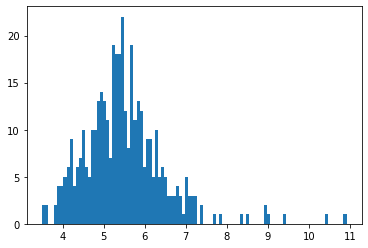

In [170]:
msad_list = []
for i in range(1, 401):
    cont_dir=f'/media/wz/7AD631A4D6316195/Projects/MSAD/outputs_32_crmnconi/Struc/CONTCAR{i}'
    pos_dir=f'/media/wz/7AD631A4D6316195/Projects/MSAD/outputs_32_crmnconi/Struc/POSCAR{i}'

    msad_list.append(np.sqrt(msad_ana_qua(cont_dir, pos_dir, 3.512, 2)['MSAD']))

print(np.mean(msad_list))
msad_list = np.array(msad_list)
plt.hist(msad_list, bins=100)

Old version

In [56]:
#* Deducing step
ind_1nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_1nn.npy')
ind_2nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_2nn.npy')
ind_3nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_3nn.npy')
ind_4nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_4nn.npy')
ind_qua1nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_qua1nn.npy')
ind_qua1nn2nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_qua1nn2nn.npy')
ind_trip1nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_trip1nn.npy')
ind_trip1nn2nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_trip1nn2nn.npy')
ind_trip1nn2nn3nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_trip1nn2nn3nn.npy')

ind_1nn_pbc = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_1nn_pbc.npy')
ind_2nn_pbc = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_2nn_pbc.npy')
ind_3nn_pbc = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_3nn_pbc.npy')
ind_4nn_pbc = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_4nn_pbc.npy')
ind_qua1nn_pbc = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_qua1nn_pbc.npy')
ind_qua1nn2nn_pbc = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_qua1nn2nn_pbc.npy')
ind_trip1nn_pbc = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_trip1nn_pbc.npy')
ind_trip1nn2nn_pbc = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_trip1nn2nn_pbc.npy')
ind_trip1nn2nn3nn_pbc = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_trip1nn2nn3nn_pbc.npy')

ind_raw = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_raw32.npy')

weight_list, energy = [], []
ce_ = CE(ind_1nn, ind_2nn, ind_3nn, ind_4nn, 
        ind_qua1nn, ind_qua1nn2nn, 
        ind_trip1nn, ind_trip1nn2nn, ind_trip1nn2nn3nn,
        ind_1nn_pbc, ind_2nn_pbc, ind_3nn_pbc, ind_4nn_pbc, 
        ind_qua1nn_pbc, ind_qua1nn2nn_pbc, 
        ind_trip1nn_pbc, ind_trip1nn2nn_pbc, ind_trip1nn2nn3nn_pbc,
        ind_raw)
atom_num = 32
msad_list = []

for i in range(1, 401):
    ind_cr = np.load(f'/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/252525/Cr25Mn25Co25Ni2532_try{i}/Cr25Mn25Co25Ni25_cr_chosen.npy')
    ind_mn = np.load(f'/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/252525/Cr25Mn25Co25Ni2532_try{i}/Cr25Mn25Co25Ni25_mn_chosen.npy')
    ind_co = np.load(f'/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/252525/Cr25Mn25Co25Ni2532_try{i}/Cr25Mn25Co25Ni25_co_chosen.npy')
    ind_ni = np.load(f'/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/252525/Cr25Mn25Co25Ni2532_try{i}/Cr25Mn25Co25Ni25_ni_chosen.npy')
    
    #* MSAD from DFT
    cont_dir=f'/media/wz/7AD631A4D6316195/Projects/MSAD/outputs_32_crmnconi/Struc/CONTCAR{i}'
    pos_dir=f'/media/wz/7AD631A4D6316195/Projects/MSAD/outputs_32_crmnconi/Struc/POSCAR{i}'

    #* Free energy
    # osz_dir = f'/media/wz/7AD631A4D6316195/Projects/MSAD/outputs_32_crmnconi/Cr25Mn25Co25Ni25_3.512_try{i}/OSZICAR'
    # oszicar = ce_.read(osz_dir)[-1]
    # e_ground = float(''.join(oszicar).split()[-6]) 

    #* Extract cluster info.
    ce_feature = ce_.config_extra(atom_num, ind_cr, ind_mn, ind_co, ind_ni)

    if np.var([ 
        len(ind_cr), len(ind_mn), len(ind_co), len(ind_ni)
    ]) <= 4:
        weight_list.append(ce_feature)
        msad_list.append(np.sqrt(msad_ana_qua(cont_dir, pos_dir, 3.512, 2)['MSAD']))
    # energy.append(e_ground)

msad_list = np.array(msad_list)
weight_list = np.array(weight_list) #* Per atom

#* Normalization
# energy_min, energy_max = np.min(energy), np.max(energy)
# energy_std = np.std(energy)
# energy_mean = np.mean(energy)
# energy = (energy - energy_mean) / energy_std

# weight_std = np.std(weight_list, axis=0)
# weight_mean = np.mean(weight_list, axis=0)
# weight_list = (weight_list - weight_mean) / weight_std

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
# weight_list = torch.from_numpy(weight_list.astype(np.float32)).clone()
# energy = torch.from_numpy(energy.astype(np.float32)).clone()
# weight_list = weight_list.to(device)
# energy = energy.reshape(-1,1).to(device)

{'gamma': {'a': 14.448446458451102, 'loc': -1.6482700257424026, 'scale': 0.24109477205301572}} 100000


,sumsquare_error,aic,bic,kl_div
gamma,122.353152,334.837112,-670566.852433,inf


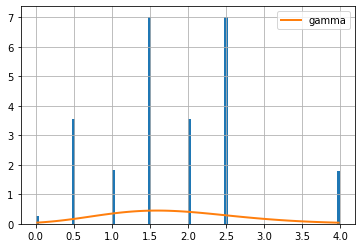

In [47]:
from fitter import Fitter
num_list, count = [], 0

for i in range(100000):
    while 1:
        n1 = np.random.randint(6,11)
        n2 = np.random.randint(6,11)
        n3 = np.random.randint(6,11)
        n4 = 32 - n1-n2-n3
        if 6 <= n4 <= 10:
            break
    num_list.append(np.var([n1, n2, n3, n4]))

valy_pair = np.array([round(i, 3) for i in num_list])
f_pair = Fitter(valy_pair, distributions = ['gamma'], timeout = 1500)
f_pair.fit()

print(f_pair.get_best(), count)
f_pair.summary()

#### The fitting part for MSAD

Find the optimal set of clusters

Text(0.5, 1.0, 'Final temp.: 0.00907998595249697 K')

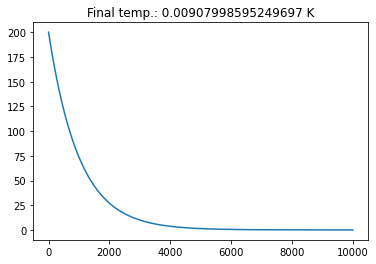

In [24]:
#* Test the setting of temperature decay.
def temp(temp_0, t, tau):
    return temp_0*np.exp(-t/tau)

t = np.linspace(0, 10000, 10000)
temp_ = temp(200, t, 1000)

plt.plot(t, temp_)
plt.title(f'Final temp.: {temp_[-1]} K')

##### SA implementation for deducing best ECI combination.

1. Operations: <code>Delete</code>, <code>Add</code>
   
   Operation on embedding list: 1 <-> 0

2. Choose the best 10 embedding lists;

Load cluster indices.

In [17]:
def extract_weight(ind_rangeL, ind_rangeU, embed, atom_num):
    weight_list, msad_list = [], []
    weight_list_ab, msad_list_ab = [], []
    ele_list, ele_list_ab = [], []
    for i in range(ind_rangeL, ind_rangeU):
        ind_cr = np.load(f'/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/252525/Cr25Mn25Co25Ni2532_try{i}/Cr25Mn25Co25Ni25_cr_chosen.npy')
        ind_mn = np.load(f'/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/252525/Cr25Mn25Co25Ni2532_try{i}/Cr25Mn25Co25Ni25_mn_chosen.npy')
        ind_co = np.load(f'/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/252525/Cr25Mn25Co25Ni2532_try{i}/Cr25Mn25Co25Ni25_co_chosen.npy')
        ind_ni = np.load(f'/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/252525/Cr25Mn25Co25Ni2532_try{i}/Cr25Mn25Co25Ni25_ni_chosen.npy')
        
        #* MSAD from DFT
        cont_dir=f'/media/wz/7AD631A4D6316195/Projects/MSAD/outputs_32_crmnconi/Struc/CONTCAR{i}'
        pos_dir=f'/media/wz/7AD631A4D6316195/Projects/MSAD/outputs_32_crmnconi/Struc/POSCAR{i}'

        #* Free energy
        # osz_dir = f'/media/wz/7AD631A4D6316195/Projects/MSAD/outputs_32_crmnconi/Cr25Mn25Co25Ni25_3.512_try{i}/OSZICAR'
        # oszicar = ce_.read(osz_dir)[-1]
        # e_ground = float(''.join(oszicar).split()[-6]) 
        
        #* Exclude the configurations whose variance between composition
        #* is greater than 4.
        if np.var([ 
            len(ind_cr), len(ind_mn), len(ind_co), len(ind_ni)
            ]) <= 4:
            #* Extract cluster info.
            ce_feature, ele_ = ce_.config_extra(atom_num, ind_cr, ind_mn, ind_co, ind_ni, embed)

            ele_list.append(ele_)
            weight_list.append(ce_feature)
            msad_list.append(np.sqrt(msad_ana_qua(cont_dir, pos_dir, 3.512, 2)['MSAD']))
        
        elif np.var([ 
            len(ind_cr), len(ind_mn), len(ind_co), len(ind_ni)
            ]) > 4 and len(ind_cr) >= 10:
            #* The abnormal part, which occupies 10% of whole dataset.
            ce_feature_ab, ele_ = ce_.config_extra(atom_num, ind_cr, ind_mn, ind_co, ind_ni, embed)

            ele_list_ab.append(ele_)
            weight_list_ab.append(ce_feature_ab)
            msad_list_ab.append(np.sqrt(msad_ana_qua(cont_dir, pos_dir, 3.512, 2)['MSAD']))
        # energy.append(e_ground)

        if i % 50 == 0:
            print(f'Iter: {i}')
        
    msad_list, msad_list_ab = np.array(msad_list), np.array(msad_list_ab)
    weight_list, weight_list_ab = np.array(weight_list), np.array(weight_list_ab) #* Per atom
    return msad_list, weight_list, msad_list_ab, weight_list_ab, ele_list, ele_list_ab

#* Deducing step
ind_1nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_1nn.npy')
ind_2nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_2nn.npy')
ind_3nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_3nn.npy')
ind_4nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_4nn.npy')
ind_5nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_5nn.npy')
ind_6nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_6nn.npy')
ind_qua1nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_qua1nn.npy')
ind_qua1nn2nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_qua1nn2nn.npy')
ind_qua111122 = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_qua111122_raw.npy')

ind_1nn_pbc = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_1nn_pbc.npy')
ind_2nn_pbc = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_2nn_pbc.npy')
ind_3nn_pbc = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_3nn_pbc.npy')
ind_4nn_pbc = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_4nn_pbc.npy')
ind_5nn_pbc = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_5nn_pbc.npy')
ind_6nn_pbc = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_6nn_pbc.npy')
ind_qua1nn_pbc = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_qua1nn_pbc.npy')
ind_qua1nn2nn_pbc = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_qua1nn2nn_pbc.npy')
ind_qua111122_pbc = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_qua111122_pbc.npy')

''' 
Thanks chatGPT for doing such *** things.
'''
pth_trip = '/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/triplet_ind/'

ind_trip111 = np.load(f'{pth_trip}ind_trip111_raw.npy')
ind_trip111_pbc = np.load(f'{pth_trip}ind_trip111_pbc.npy')
ind_trip112 = np.load(f'{pth_trip}ind_trip112_raw.npy')
ind_trip112_pbc = np.load(f'{pth_trip}ind_trip112_pbc.npy')
ind_trip113 = np.load(f'{pth_trip}ind_trip113_raw.npy')
ind_trip113_pbc = np.load(f'{pth_trip}ind_trip113_pbc.npy')
ind_trip114 = np.load(f'{pth_trip}ind_trip114_raw.npy')
ind_trip114_pbc = np.load(f'{pth_trip}ind_trip114_pbc.npy')
ind_trip123 = np.load(f'{pth_trip}ind_trip123_raw.npy')
ind_trip123_pbc = np.load(f'{pth_trip}ind_trip123_pbc.npy')
ind_trip125 = np.load(f'{pth_trip}ind_trip125_raw.npy')
ind_trip133 = np.load(f'{pth_trip}ind_trip133_raw.npy')
ind_trip134 = np.load(f'{pth_trip}ind_trip134_raw.npy')
ind_trip125_pbc = np.load(f'{pth_trip}ind_trip125_pbc.npy')
ind_trip133_pbc = np.load(f'{pth_trip}ind_trip133_pbc.npy')
ind_trip134_pbc = np.load(f'{pth_trip}ind_trip134_pbc.npy')
ind_trip135 = np.load(f'{pth_trip}ind_trip135_raw.npy')
ind_trip145 = np.load(f'{pth_trip}ind_trip145_raw.npy')
ind_trip155 = np.load(f'{pth_trip}ind_trip155_raw.npy')
ind_trip135_pbc = np.load(f'{pth_trip}ind_trip135_pbc.npy')
ind_trip145_pbc = np.load(f'{pth_trip}ind_trip145_pbc.npy')
ind_trip155_pbc = np.load(f'{pth_trip}ind_trip155_pbc.npy')
ind_trip224 = np.load(f'{pth_trip}ind_trip224_raw.npy')
ind_trip233 = np.load(f'{pth_trip}ind_trip233_raw.npy')
ind_trip255 = np.load(f'{pth_trip}ind_trip255_raw.npy')
ind_trip224_pbc = np.load(f'{pth_trip}ind_trip224_pbc.npy')
ind_trip233_pbc = np.load(f'{pth_trip}ind_trip233_pbc.npy')
ind_trip255_pbc = np.load(f'{pth_trip}ind_trip255_pbc.npy')
ind_trip334 = np.load(f'{pth_trip}ind_trip334_raw.npy')
ind_trip335 = np.load(f'{pth_trip}ind_trip335_raw.npy')
ind_trip345 = np.load(f'{pth_trip}ind_trip345_raw.npy')
ind_trip334_pbc = np.load(f'{pth_trip}ind_trip334_pbc.npy')
ind_trip335_pbc = np.load(f'{pth_trip}ind_trip335_pbc.npy')
ind_trip345_pbc = np.load(f'{pth_trip}ind_trip345_pbc.npy')
ind_trip444 = np.load(f'{pth_trip}ind_trip444_raw.npy')
ind_trip455 = np.load(f'{pth_trip}ind_trip455_raw.npy')
ind_trip444_pbc = np.load(f'{pth_trip}ind_trip444_pbc.npy')
ind_trip455_pbc = np.load(f'{pth_trip}ind_trip455_pbc.npy')

#* 21 x quadruplets
pth_sav = '/media/wz/a7ee6d50-691d-431a-8efb-b93adc04896d/Github/MATools/CE_MC/runs/demo/20221216_msadGA/'

with open(f'{pth_sav}ind_quapbc.json', 'r') as f:
    ind_quapbc = json.load(f)

with open(f'{pth_sav}ind_quaraw.json', 'r') as f:
    ind_quaraw = json.load(f)

ind_raw = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_raw32.npy')

ce_ = CE(ind_1nn, ind_2nn, ind_3nn, ind_4nn, ind_5nn, ind_6nn,
        ind_qua1nn, ind_qua1nn2nn, ind_qua111122,

        ind_trip111, ind_trip112, ind_trip113, ind_trip114,
        ind_trip123, ind_trip125, ind_trip133, ind_trip134, 
        ind_trip135, ind_trip145, ind_trip155, ind_trip224,
        ind_trip233, ind_trip255, ind_trip334, ind_trip335, 
        ind_trip345, ind_trip444, ind_trip455, 

        ind_1nn_pbc, ind_2nn_pbc, ind_3nn_pbc, ind_4nn_pbc, 
        ind_5nn_pbc, ind_6nn_pbc,
        ind_qua1nn_pbc, ind_qua1nn2nn_pbc, ind_qua111122_pbc,

        ind_trip111_pbc, ind_trip112_pbc, ind_trip113_pbc, ind_trip114_pbc,
        ind_trip123_pbc, ind_trip125_pbc, ind_trip133_pbc, ind_trip134_pbc, 
        ind_trip135_pbc, ind_trip145_pbc, ind_trip155_pbc, ind_trip224_pbc,
        ind_trip233_pbc, ind_trip255_pbc, ind_trip334_pbc, ind_trip335_pbc, 
        ind_trip345_pbc, ind_trip444_pbc, ind_trip455_pbc, 

        ind_quaraw, ind_quapbc, ind_raw, use_pbc=False)

embed_val = np.ones(49).astype(bool)

embed_type = [
    'pair1', 'pair2', 'pair3', 'pair4', 
    'tri111', 'tri112', 'tri113', 'tri114',
    'tri123', 'tri125', 'tri133', 'tri134',
    'tri135', 'tri145', 'tri155', 'tri224',
    'tri233', 'tri255', 'tri334', 'tri335',
    'tri345', 'tri444', 'tri455',
    'qua111111', 'qua111112', 'qua111122',
    'pair5', 'pair6',
    #? Quadruplets x 21
    '111123', '111133', '111134', '111224',
    '111233', '111333', '111334', '112233',
    '112234', '112333', '112334', '113334',
    '113344', '113444', '122334', '123333',
    '133444', '222244', '222444', '223333', '223334',]

#* Lookup table of the indices in weight for each cluster.
embed_book = [
    [i for i in range(0,9)],
    [i for i in range(9,18)],
    [i for i in range(18,27)],
    [i for i in range(27,36)],
    [i for i in range(36,63)],
    [i for i in range(63,90)],
    [i for i in range(90,117)],
    [i for i in range(117,144)],
    [i for i in range(144,171)],
    [i for i in range(171,198)],
    [i for i in range(198,225)],
    [i for i in range(225,252)],
    [i for i in range(252,279)],
    [i for i in range(279,306)],
    [i for i in range(306,333)],
    [i for i in range(333,360)],
    [i for i in range(360,387)],
    [i for i in range(387,414)],
    [i for i in range(414,441)],
    [i for i in range(441,468)],
    [i for i in range(468,495)],
    [i for i in range(495,522)],
    [i for i in range(522,549)],
    [i for i in range(549,630)],
    [i for i in range(630,711)],
    [i for i in range(711, 792)],
    [i for i in range(792, 801)],
    [i for i in range(801, 810)],
]

qua_embed = np.linspace(810, 810+81*21-1, 81*21).reshape(21, 81).astype(int).tolist()
embed_book += qua_embed
embed_list = dict(zip(embed_type, embed_val))
embed_book = np.array(embed_book, dtype=object)

#* Re-calculate the weight_list and MSAD_list,
#* Time consuming better not to do that.
# msad_list, weight_list, msad_list_ab, weight_list_ab, ele_list, ele_list_ab = extract_weight(1, 401, embed_list, atom_num=32)

Save correlation functions and MSAD value list.

In [198]:
pth_sav = '/media/wz/a7ee6d50-691d-431a-8efb-b93adc04896d/Github/MATools/CE_MC/runs/demo/20221226_msadGA/'
np.save(f'{pth_sav}weight_49_raw', weight_list)
np.save(f'{pth_sav}msad_list', msad_list)
np.save(f'{pth_sav}weight_49_raw_abnormal', weight_list_ab)
np.save(f'{pth_sav}msad_list_abnormal', msad_list_ab)
np.save(f'{pth_sav}ele_list_all', np.concatenate([ele_list, ele_list_ab], axis=0))

In [199]:
np.concatenate([weight_list, weight_list_ab], axis=0).shape

(385, 2511)

#### Main

Block 1: GA implementation. (recommend)

Block 2: SA implementation. (much simpler)

In [89]:
class genetic:
    def __init__(self, mut_prob, group_size, embed_book, 
            weight, weight_ab, msad, msad_ab, use_scalar=False):

        self.mut_prob = mut_prob
        self.group_size = group_size
        self.embed_book = embed_book
        #* Weight parameters in full length
        self.weight = weight
        self.weight_ab = weight_ab
        self.msad_list = msad
        self.msad_list_ab = msad_ab
        self.use_scalar = use_scalar

    @staticmethod
    def softmax(x):
        exps = np.exp(x - np.max(x))
        return exps / np.sum(exps)

    #* For a single embedding list.
    @staticmethod
    def embed_extra(embed_book, weight_raw, embed_list):
        #* Extract the weight
        false_ind = np.where(embed_list==0)[0]
        if len(false_ind) >= 1:
            delete_ind = np.concatenate(embed_book[false_ind], axis=0)
            weight_n = np.delete(weight_raw, delete_ind, axis=1)
            #* Mean and Variance
        else:
            weight_n = weight_raw
            
        return weight_n

    #* Apply scalar for each sub-cluster.
    @staticmethod
    def scalar_(weight_list):
        scaler = StandardScaler().fit(weight_list)
        return scaler

    def fitness(self, embed_list):
        fit_list = []
        ''' embed_list (N x M) -> real weights -> score'''
        for i in range(len(embed_list)):
            #* Extract the weight
            false_ind = np.where(embed_list[i]==0)[0]
            if len(false_ind) >= 1:
                delete_ind = np.concatenate(self.embed_book[false_ind], axis=0)
                weight_n = np.delete(self.weight, delete_ind, axis=1)
                weight_n_ab = np.delete(self.weight_ab, delete_ind, axis=1)
            else:
                weight_n = self.weight
                weight_n_ab = self.weight_ab
            #* Return the score (fitness)
            #? OLD version: train on whole set and do 5-fold CV
            # clf = LassoLarsIC().fit(weight_n, self.msad_list)
            # cv_ = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
            # score = cross_val_score(
            #     clf, weight_n, self.msad_list, 
            #     cv=cv_, n_jobs=-1, scoring='neg_mean_squared_error').mean()
            #? NEW version: train on splited set and do cv on test
            #? with repeating 5 times. 
            n_samples = weight_n.shape[0]
            regr = RidgeCV(alphas=np.logspace(-2,3,5), cv=5)
            score_list = []

            #* Use dynamic scalar
            if self.use_scalar:
                scalar_n = genetic.scalar_(
                    np.concatenate([weight_n, weight_n_ab], axis=0))
                weight_n = scalar_n.transform(weight_n)
                weight_n_ab = scalar_n.transform(weight_n_ab)

            cv = ShuffleSplit(n_splits=3, test_size=0.1, random_state=0)
            for train, test in cv.split(np.arange(n_samples)):
                weight_train, msad_train = weight_n[train], self.msad_list[train]
                weight_test, msad_test = weight_n[test], self.msad_list[test]
                # print(weight_test.shape)
                #* Insert the abnormal dist. 
                #* Result in: 10% test set + abnormal set.
                weight_test = np.concatenate([weight_test, weight_n_ab], axis=0)
                msad_test = np.concatenate([msad_test, self.msad_list_ab], axis=0)

                regr.fit(weight_train, msad_train)
                score_list.append(regr.score(weight_test, msad_test)) 

            score = np.mean(score_list)
            fit_list.append(score)

        fit_list = np.array(fit_list)
        fit_list_raw = fit_list.copy()
        #* Apply a softmax before selecting
        fit_list = genetic.softmax(fit_list)
        #* Reinforce the prob.?
        fit_list = np.power(np.array(fit_list), 1)
        #* Probability of survive
        ind_h2l = np.argsort(fit_list)[::-1]
        #* Weight with the highest score.
        p0 = (fit_list/np.sum(fit_list))[ind_h2l[0]]
        best_embed = embed_list[ind_h2l[0]]
        best_score = fit_list_raw[ind_h2l[0]]

        p_list = np.zeros(len(ind_h2l))
        for i in range(len(ind_h2l)):
            p_list[ind_h2l[i]] = p0*(1-p0)**i
        
        if len(fit_list) > self.group_size:
            ind_survive = np.random.choice(np.arange(len(fit_list)), self.group_size, p=p_list/np.sum(p_list), replace=False)
            embed_list = embed_list[ind_survive]
            
        #* Return the score 
        return embed_list, np.max(fit_list_raw), np.min(fit_list_raw), best_embed, best_score

    @staticmethod
    def multi(embed_list, breeding_list, count, re_time):

        #* BREEDING(
        if count >= len(breeding_list):
            breeding_list_chosen = breeding_list[np.random.choice(
                np.arange(len(breeding_list)), size=2, replace=False)
            ]
            embed_list = np.concatenate([ 
                embed_list, breeding_list_chosen
            ], axis=0)

        ind_list = np.arange(len(embed_list))
        embed_list_n = []

        for _ in range(re_time):
            
            chosen_lists = embed_list[np.random.choice(ind_list, size=2, replace=True)]
            #* Length of multiplication part
            len_multi = np.random.randint(
                len(embed_list//2)-len(embed_list//8), len(embed_list//2)+len(embed_list//8)+1
            )
            # print(chosen_lists)
            if _%2 == 0:
                chosen_lists[0][len_multi:], chosen_lists[1][len_multi:] = (
                    chosen_lists[1][len_multi:], chosen_lists[0][len_multi:])
            elif _%2 == 1:
                chosen_lists[1][:len_multi], chosen_lists[0][:len_multi] = (
                    chosen_lists[0][:len_multi], chosen_lists[1][:len_multi])
            embed_list_n += chosen_lists.tolist()

        #* Avoid the 0-list
        nan_ind = np.where(np.linalg.norm(embed_list, axis=1)==0)[0]
        if len(nan_ind) >= 1:
            for nan in nan_ind:
                embed_list[nan][0] = 1

        #* Return R = re_time*2 X len matrix
        return np.unique(np.array(embed_list_n), axis=0)

    def mut(self, embed_list):
        #* Better to set j at relatively low level
        for i in range(len(embed_list)):
            for j in range(1): #* Repeat twice for mutation.
                if np.random.rand() < self.mut_prob:
                    rand_ind = np.random.randint(len(embed_list[0]))
                    val = embed_list[i][rand_ind]
                    embed_list[i][rand_ind] = np.abs(val-1)

        #* Avoid the 0-list
        nan_ind = np.where(np.linalg.norm(embed_list, axis=1)==0)[0]
        if len(nan_ind) >= 1:
            for nan in nan_ind:
                embed_list[nan][0] = 1

        return np.unique(np.array(embed_list), axis=0)

#* Load correlation functions
weight_pth = './runs/demo/20221216_msadGA/weight_49_raw.npy'
weight_list = np.load(weight_pth)
weight_pth_ab = './runs/demo/20221216_msadGA/weight_49_raw_abnormal.npy'
weight_list_ab = np.load(weight_pth_ab)
#* Standarize features
weight_list_all = np.concatenate([weight_list, weight_list_ab], axis=0)

#* Load MSAD lists
msad_pth = './runs/demo/20221216_msadGA/msad_list.npy'
msad_list = np.load(msad_pth)
msad_pth_ab = './runs/demo/20221216_msadGA/msad_list_abnormal.npy'
msad_list_ab = np.load(msad_pth_ab)

#* Load embed book
embed_pth = './runs/demo/20221216_msadGA/embed_book49.npy'
embed_book = np.load(embed_pth, allow_pickle=True)

#* Normalization of weight list.
dyna_scalar = False
if not dyna_scalar:
    scaler = StandardScaler().fit(weight_list_all)
    weight_list = scaler.transform(weight_list)
    weight_list_ab = scaler.transform(weight_list_ab)

#* Hyperparams for GA.
trial_step = 1000
mut_prob, group_size = 0.06, 30
len_cluster = 49
re_time_multi = 60
len_chosenindividual = 10
best_embed, best_score = np.zeros((len_chosenindividual, len_cluster)), -np.ones(len_chosenindividual)*2
#* Initialize the genetic algo.
gen = genetic(mut_prob, group_size, embed_book, 
    weight_list, weight_list_ab, msad_list, msad_list_ab,
    use_scalar = dyna_scalar)

#* Initialize the embedding list, R = 30xlen(cluster).
embed_val = np.tile(np.concatenate([np.ones(8), np.zeros(len_cluster-8)]), group_size)
np.random.shuffle(embed_val)
embed_val = embed_val.reshape(group_size, len_cluster)
# embed_val = best_embed_ #* Continue computing.

score_h, score_l = [], []
count = 0

for i in range(trial_step):
    
    embed_val = np.unique(embed_val, axis=0) #* Remove duplicates.
    embed_val = gen.multi(embed_val, best_embed, count, re_time=re_time_multi) #* Multiplication
    embed_val = gen.mut(embed_val) #* Mutation
    embed_val, max_score, min_score, top_embed, top_score = gen.fitness(embed_val) #* Natural Selection

    #* Updating the embed list with best performance.
    if top_score > np.max(best_score):
        best_embed[count%len_chosenindividual] = top_embed
        best_score[count%len_chosenindividual] = top_score
        count += 1

    clear_output(True)
    score_h.append(max_score)
    score_l.append(min_score)
    if i%5 == 0:
        x_axis = np.linspace(0, len(score_h)-1, len(score_h))
        plt.plot(x_axis, score_h)
        plt.plot(x_axis, score_l)
        plt.title(f'Iter: {i}, Max Score: {np.max(score_h)}')
        plt.fill_between(x_axis, score_l, score_h, alpha=0.2, color=cm.viridis(0.5))
        plt.show()

KeyboardInterrupt: 

Seeking alpha (
    
for the linear model.

In [ ]:
for i in range(len(best_embed_)):
    #* Extract the weight
    false_ind = np.where(best_embed_[i]==0)[0]
    delete_ind = np.concatenate(embed_book[false_ind], axis=0)
    weight_n = np.delete(weight_list, delete_ind, axis=1)
    #* Return the score (fitness)
    clf = LassoCV(
        alphas=np.logspace(-3,3), 
        cv=5,
        max_iter=5000).fit(weight_n, msad_list)
    print(clf.alpha_)

Display the chosen embedding lists.

In [76]:
best_score

array([0.35523065, 0.36051654, 0.36103808, 0.36332571, 0.36503975,
       0.37315599, 0.38181651, 0.35052624, 0.3521218 , 0.35279833])

In [ ]:
best_embed_ = best_embed.copy()
best_embed_ = np.unique(best_embed_, axis=0)
print(len(best_embed_), best_embed_)

In [91]:
chosen_embed_ = best_embed_[-4]
chosen_embed_1 = chosen_embed_.copy()
chosen_embed_1 = np.load('./runs/demo/20230103/chosen_embed.npy')
# chosen_embed_1[2] = 1.0 #* pair3
# chosen_embed_1[26] = 0.0 #* pair5

msad_all = np.concatenate([msad_list, msad_list_ab], axis=0)
weight_chosen = genetic.embed_extra(embed_book, weight_list, chosen_embed_1)
weight_chosen_all = genetic.embed_extra(embed_book, weight_list_all, chosen_embed_)

best_embed_dict = dict(zip(embed_type, chosen_embed_1))

# dyna_scalar = True #* Use dynamic scalar?
#* In case of dynamic scalar, we need to normalize the weight.
if dyna_scalar:
    scaler = StandardScaler().fit(weight_chosen_all)
    weight_chosen = scaler.transform(weight_chosen)

clf_ga = RidgeCV(alphas=np.logspace(-3,3), cv=10).fit(weight_chosen, msad_list)
# clf_ga_all = RidgeCV(alphas=np.logspace(-3,3), cv=10).fit(weight_chosen_all, msad_all)
''' 
1. Transform the new weights into normalized form. z = (x - u) / s
2. Apply the model to new weights, return dist. under that composition.
'''

' \n1. Transform the new weights into normalized form. z = (x - u) / s\n2. Apply the model to new weights, return dist. under that composition.\n'

In [92]:
print(chosen_embed_1)

[1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0.
 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0.
 0.]


In [80]:
eci_ind = np.where(np.array(chosen_embed_1) == 1.0)[0]
eci_type = [embed_type[i] for i in eci_ind.astype(int)]
eci_type

['pair1',
 'pair2',
 'pair3',
 'pair4',
 'tri112',
 'tri114',
 'tri123',
 'tri133',
 'tri255',
 'tri335',
 'tri444',
 'qua111112',
 'qua111122',
 'pair6',
 '111123',
 '112233',
 '112333',
 '113334',
 '133444']

In [272]:
clf_pthsav = '/media/wz/a7ee6d50-691d-431a-8efb-b93adc04896d/Github/MATools/CE_MC/runs/demo/20230105/eq_clf_msad.sav'
pickle.dump(clf_ga, open(clf_pthsav, 'wb'))

In [81]:
clf_ga.score(weight_chosen, msad_list)

0.8446349651876625

SA implementation, simple but not sufficient.

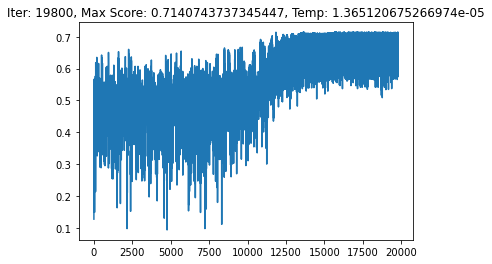

In [ ]:
#* Let the temperature decay
trial_step = 20000
temp_0 = 200
temp = temp_0
tau = 1200
def temp_d(temp_0, t, tau):
    return temp_0*np.exp(-t/tau)

#* Extract the effective weight according to the embedding list
def embed_extra(weight, embed_list, lookbook,):
    false_ind = np.where(embed_list==0)[0]
    delete_ind = np.concatenate(embed_book[false_ind], axis=0)
    weight_ = np.delete(weight, delete_ind, axis=1)
    return weight_

def random_flip(list_, prob):
    if np.random.rand() < prob:
        random_ind = np.random.randint(0, len(list_))
        val = list_[random_ind]

        list_n = list_.copy()
        #* Flip the encodes from 0 -> 1 or 1 -> 0
        list_n[random_ind] = np.abs(val-1)

    else:
        list_n = list_

    return list_n

#* Initialize the embedding list.
embed_val = np.zeros(28)
weight_list_r = embed_extra(weight_list, embed_val, embed_book)

#* Best embedding list corresponding to the highest CV-score.
def embed_chosen(list, score, pop_size=10):
    len_embed = len(list)
    list, score = np.array(list), np.array(score)
    if len_embed > pop_size:
        #* Get the indices of the highest 10 values
        sorted_score = score.argsort()
        high10_index = sorted_score[-pop_size:]
        list, score = list[high10_index], score[high10_index]
    return list.tolist(), score.tolist()

chosen_embed = []
chosen_score = []
best_score = 0

len_embed = len(embed_val)
score_ = 0
score_list = []

for i in range(trial_step):
    '''
    1. Randomly choose one encode to flip.
    2. 50% choose another one. 
    3. 25% choose the 3rd one.
    '''
    embed_val_ = random_flip(embed_val, prob=1)
    embed_val_ = random_flip(embed_val_, prob=1/2)
    embed_val_ = random_flip(embed_val_, prob=1/4)

    weight_list_n = embed_extra(weight_list, embed_val_, embed_book)
    # embed_list = dict(zip(embed_type, embed_val_.astype(bool)))
    # msad_list, weight_list = extract_weight(1, 401, embed_list, atom_num=32)

    clf = RidgeCV(alphas=np.logspace(-2, 1, 10)).fit(weight_list_n, msad_list.reshape(-1,1))
    score = clf.score(weight_list_n, msad_list.reshape(-1,1))

    if score >= best_score:
        best_score = score.copy()
        chosen_embed.append(embed_val_.tolist())
        chosen_score.append(score)
        #* Return the chosen one(s)
        chosen_embed, chosen_score = embed_chosen(chosen_embed, chosen_score)

    if np.random.rand()<np.min([1,np.exp((score-score_)/temp)]):
        embed_val = embed_val_
        score_ = score

    #* Temp decay
    temp = temp_d(temp_0, i, tau)

    clear_output(True)
    score_list.append(score)
    if i%200 == 0:
        plt.plot(score_list)
        plt.title(f'Iter: {i}, Max Score: {best_score}, Temp: {temp}')

        plt.show()

Old versions

In [141]:
res_list = []
for i in range(100):
    msad_train, msad_test, weight_train, weight_test = train_test_split(
        msad_list.reshape(-1,1), weight_list, test_size=0.05)
    
    #*Linear regression
    weight_train_, msad_train_ = weight_train.clone(), msad_train.clone()
    weight_test_, msad_test_ = weight_test.clone(), msad_test.clone()

    clf_ = BayesianRidge().fit(weight_train.detach().cpu().numpy(), msad_train.detach().cpu().numpy().flatten())
    msad_predict_lr = clf_.predict(weight_test.detach().cpu().numpy())

    res = msad_predict_lr-msad_test.numpy().flatten()
    res_list += (res.tolist())

np.linalg.norm(res_list)

36.18699289587543

In [57]:
msad_train, msad_test, weight_train, weight_test = train_test_split(
    msad_list.reshape(-1,1), weight_list, test_size=0.05)

In [58]:
#*Linear regression
weight_train_, msad_train_ = weight_train, msad_train
weight_test_, msad_test_ = weight_test, msad_test

#* Bayesian Ridge LR
clf_ = BayesianRidge().fit(weight_train_, msad_train_.flatten())
msad_predict_lr = clf_.predict(weight_test_)

In [59]:
msad_predict_lr

array([30.74524551, 24.99662632, 37.40761813, 33.43127198, 34.57519602,
       28.42163488, 36.30333264, 21.3395938 , 24.8404661 , 33.67569673,
       37.34763519, 32.73615193, 25.67677067, 27.87344999, 23.94522532,
       22.13018359, 31.27400267, 25.57877519, 35.51733037])

In [35]:
#*Linear regression
weight_train_, msad_train_ = weight_train.clone(), msad_train.clone()
weight_test_, msad_test_ = weight_test.clone(), msad_test.clone()

#* Gaussian Process regression
# kernel = DotProduct() + WhiteKernel()
kernel = RationalQuadratic()
gpr = GaussianProcessRegressor(kernel=kernel,
    random_state=0).fit(weight_train_.detach().cpu().numpy(), msad_train_.detach().cpu().numpy().flatten())
msad_predict_lr = gpr.predict(weight_test_.detach().cpu().numpy())

In [ ]:
plt.plot(msad_predict_lr-msad_test.numpy().flatten())
print(np.linalg.norm(msad_predict_lr-msad_test.numpy().flatten()))

In [13]:
import pickle
date = '20221209'
pth_lr = './runs/demo/'
create_dir(pth_lr+date)
name = '/gpr_msad.sav'
pickle.dump(gpr, open(pth_lr+date+name, 'wb'))

Created Directory :  /media/wz/a7ee6d50-691d-431a-8efb-b93adc04896d/Github/MATools/CE_MC/runs/demo/20221209


Now comes the current version. (2022.12)

To calculate the **TURE** MSAD in randomized states?

<i> **Method 1:** </i>

1. Generate configs without constraints.

2. Put those configs into CE prediction.

3. The outputs must follow a distribution that represents the latent dist. at 0 K.

Then take **ensemble average** of outputs to obtain $MSAD^{1/2}$.

MSAD for Cr30Mn15Co27: 5.597680929261965 pm
MSAD for Cr40Mn5Co27: 5.7118100966098195 pm
MSAD for Cr40Mn10Co25: 5.774531984647448 pm
MSAD for Cr25Mn25Co25: 5.555366478223493 pm


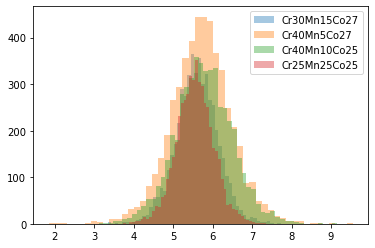

In [93]:
ele_list_predict, weight_list_predict = [], []

ce_ = CE(ind_1nn, ind_2nn, ind_3nn, ind_4nn, ind_5nn, ind_6nn,
        ind_qua1nn, ind_qua1nn2nn, ind_qua111122,

        ind_trip111, ind_trip112, ind_trip113, ind_trip114,
        ind_trip123, ind_trip125, ind_trip133, ind_trip134, 
        ind_trip135, ind_trip145, ind_trip155, ind_trip224,
        ind_trip233, ind_trip255, ind_trip334, ind_trip335, 
        ind_trip345, ind_trip444, ind_trip455, 

        ind_1nn_pbc, ind_2nn_pbc, ind_3nn_pbc, ind_4nn_pbc, 
        ind_5nn_pbc, ind_6nn_pbc,
        ind_qua1nn_pbc, ind_qua1nn2nn_pbc, ind_qua111122_pbc,

        ind_trip111_pbc, ind_trip112_pbc, ind_trip113_pbc, ind_trip114_pbc,
        ind_trip123_pbc, ind_trip125_pbc, ind_trip133_pbc, ind_trip134_pbc, 
        ind_trip135_pbc, ind_trip145_pbc, ind_trip155_pbc, ind_trip224_pbc,
        ind_trip233_pbc, ind_trip255_pbc, ind_trip334_pbc, ind_trip335_pbc, 
        ind_trip345_pbc, ind_trip444_pbc, ind_trip455_pbc, 

        ind_quaraw, ind_quapbc, ind_raw, use_pbc=True)

# for i in range(500):
#     ele_list = ele_list_gen(0.4, 0.05, 0.4, 0.1, 32)
#     ele_list_predict.append(ele_list.tolist())
#     weight_list_predict.append((ce_.cluster_extra(
#         np.tile(ele_list, 27), embed_list)))
''' 
The configurations without **constraints** on randomness
and **normalization** will be generated by 
</MSAD_predict/weight_extract.py>
and stored in <./20221216_msadGA/configs> folder,
named by its average composition.
'''

compo_mat = [
        [30, 15, 27],
        [40, 5, 27], 
        [40, 10, 25],
        [25, 25, 25]
]
msad_mat, type_mat = [], []

raw_scalar = True
dyna_scalar = False
assert raw_scalar != dyna_scalar, print('Only one scaler can be used!')

load_model = False
model_pth = './runs/demo/20230103/eq_clf_msad.sav'

for compo in compo_mat:
        a1, a2, a3 = compo
        atomic_ratio = f'{a1}_{a2}_{a3}.npy'
        config = np.load(f'/media/wz/a7ee6d50-691d-431a-8efb-b93adc04896d/Github/MATools_buffer/msadGA/202212/configs/{atomic_ratio}')

        if raw_scalar:
                weight_list_predict = scaler.transform(config)
        else:
                weight_list_predict = config

        #* NEW weight matrix remove the zero term.
        weight_list_prenew = genetic.embed_extra(embed_book, 
                                weight_list_predict, 
                                chosen_embed_1)

        #* RAW weight matrix in FULL dimension./ SUB dimension.
        if dyna_scalar:
                weight_list_prenew = scaler.transform(weight_list_prenew)

        if load_model:
                clf_ga = pickle.load(open(model_pth, 'rb'))
                
        msad_list_predict = clf_ga.predict(weight_list_prenew)
        print(f'MSAD for Cr{a1}Mn{a2}Co{a3}: {np.mean(msad_list_predict)} pm')
        msad_mat.append(msad_list_predict.flatten())
        type_mat.append(f'Cr{a1}Mn{a2}Co{a3}')
        
# print(np.mean(msad_list_predict))
for msad_list_predict, type_ in zip(msad_mat, type_mat):
        plt.hist(msad_list_predict, bins=50, label=type_, alpha=0.4)
        
plt.legend()
plt.show()

<i> **Method 2** </i>

Calculate the weight matrix of **randomized** states.

Put those weights into linear model and get **precise** prediction.

In [94]:
ce_ = CE(ind_1nn, ind_2nn, ind_3nn, ind_4nn, ind_5nn, ind_6nn,
        ind_qua1nn, ind_qua1nn2nn, ind_qua111122,

        ind_trip111, ind_trip112, ind_trip113, ind_trip114,
        ind_trip123, ind_trip125, ind_trip133, ind_trip134, 
        ind_trip135, ind_trip145, ind_trip155, ind_trip224,
        ind_trip233, ind_trip255, ind_trip334, ind_trip335, 
        ind_trip345, ind_trip444, ind_trip455, 

        ind_1nn_pbc, ind_2nn_pbc, ind_3nn_pbc, ind_4nn_pbc, 
        ind_5nn_pbc, ind_6nn_pbc,
        ind_qua1nn_pbc, ind_qua1nn2nn_pbc, ind_qua111122_pbc,

        ind_trip111_pbc, ind_trip112_pbc, ind_trip113_pbc, ind_trip114_pbc,
        ind_trip123_pbc, ind_trip125_pbc, ind_trip133_pbc, ind_trip134_pbc, 
        ind_trip135_pbc, ind_trip145_pbc, ind_trip155_pbc, ind_trip224_pbc,
        ind_trip233_pbc, ind_trip255_pbc, ind_trip334_pbc, ind_trip335_pbc, 
        ind_trip345_pbc, ind_trip444_pbc, ind_trip455_pbc, 

        ind_quaraw, ind_quapbc, ind_raw, use_pbc=True)

In [97]:
atomic_ratio = np.array([0.25, 0.25, 0.25, 0.25])

#* Scalar part
chosen_embed_ = np.load('./runs/demo/20230103/chosen_embed.npy')
scaler_raw = StandardScaler().fit(weight_list_all)
scaler_use = True
if scaler_use:
    ideal_weight = scaler_raw.transform(ce_.ideal_extract(atomic_ratio).reshape(1,-1))
else:
    ideal_weight = ce_.ideal_extract(atomic_ratio).reshape(1,-1)

ideal_weight_chosen = genetic.embed_extra(embed_book, 
                                ideal_weight, 
                                chosen_embed_1)

#* Model part
load_model = False
model_pth = './runs/demo/20230103/eq_clf_msad.sav'
if load_model:
    regr_ga = pickle.load(open(model_pth, 'rb'))
else:
    regr_ga = clf_ga

msad_list_predict = regr_ga.predict(ideal_weight_chosen)
msad_list_predict

array([5.53697172])

#### Maybe the last part of the linear model

Calculate and draw the $\partial{MSAD^{1/2}}/\partial{(A/B)}$ plot.

In [107]:
def ratio_msad(atom_ind1: int, atom_ind2: int):
    a1, a2 = embed_type[atom_ind1], embed_type[atom_ind2]
    c_1_list = np.linspace(0.01, 0.49, 100)
    c_2_list = 0.5 - c_1_list
    ratio_list = c_1_list/c_2_list
    log_ratiolist = np.log(ratio_list)
    msad_predict_list = []

    for c_1, c_2 in zip(c_1_list, c_2_list):
        atomic_ratio = np.array([0.25, 0.25, 0.25, 0.25])
        atomic_ratio[[atom_ind1, atom_ind2]] = c_1, c_2
        ideal_weight = scaler_raw.transform(ce_.ideal_extract(atomic_ratio).reshape(1,-1))
        ideal_weight_chosen = genetic.embed_extra(embed_book, ideal_weight, chosen_embed_)
        msad_predict = regr_ga.predict(ideal_weight_chosen)[0]

        msad_predict_list.append(msad_predict)
    
    return ratio_list, log_ratiolist, msad_predict_list, a1+'/'+a2
    
# ratio_, msad_, type_ = ratio_msad(0, 1)
# type_

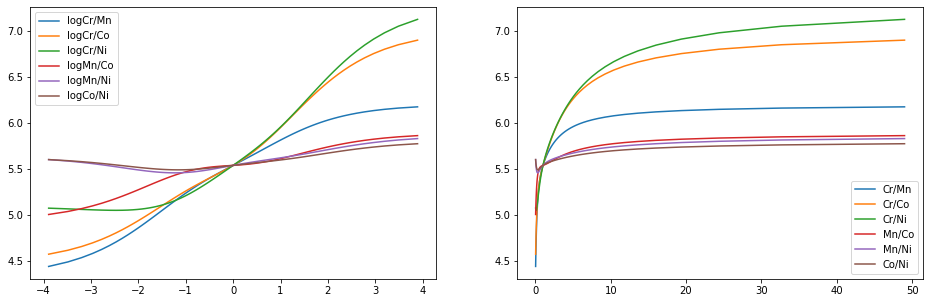

In [111]:
ce_ratioresult = {}
embed_type = ['Cr', 'Mn', 'Co', 'Ni']

fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for i, j in combinations(range(4), 2):
    ratio_predict, logratio_predict, msad_predict, type_predict = ratio_msad(i, j)
    ce_ratioresult[type_predict+'_ratio'] = ratio_predict
    ce_ratioresult[type_predict+'_msad'] = msad_predict
    ax1.plot(logratio_predict, msad_predict, label='log'+type_predict)
    ax2.plot(ratio_predict, msad_predict, label=type_predict)

ax1.legend()
ax2.legend()

plt.show()

In [ ]:
pth_sav = './runs/demo/20230112_result/'

# Save the dict
with open(f'{pth_sav}ce_ratioresult.pkl', 'wb') as f:
    pickle.dump(ce_ratioresult, f)

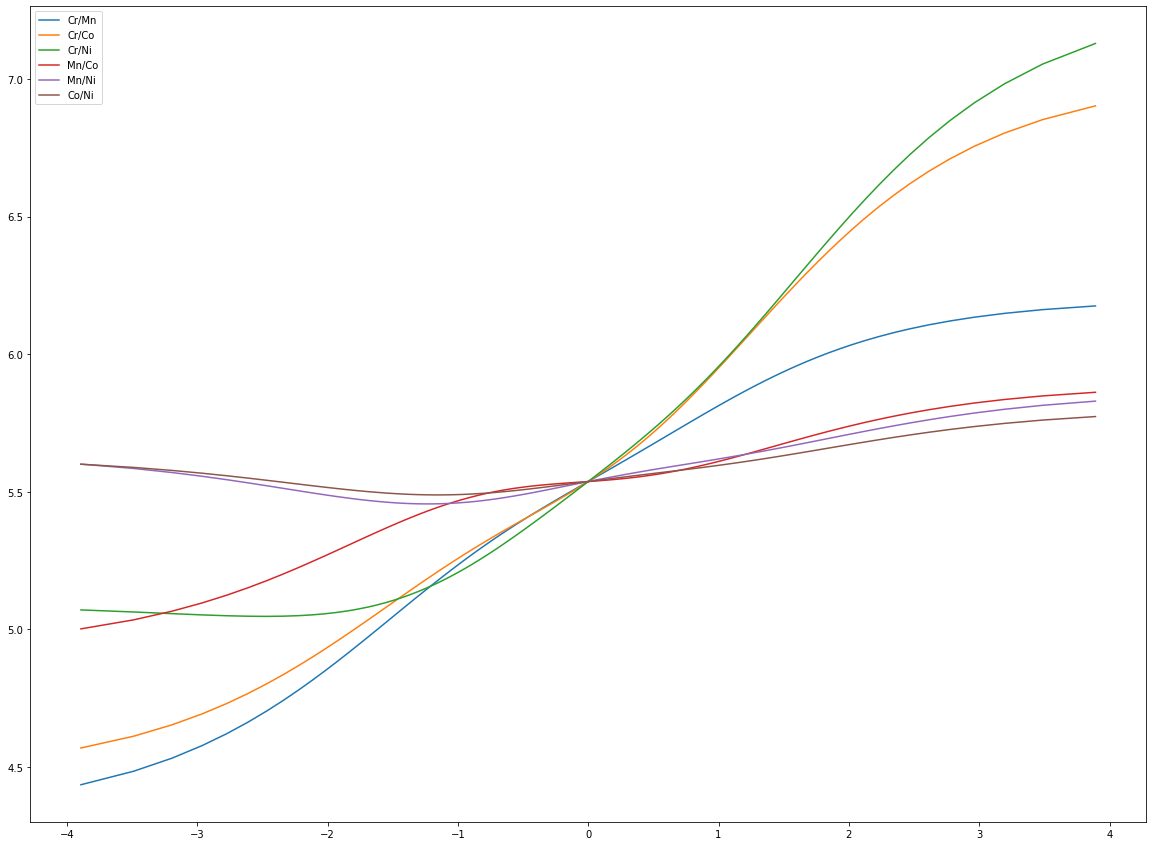

In [118]:
# Load the dict
with open(f'{pth_sav}ce_ratioresult.pkl', 'rb') as f:
    ce_ratioresult = pickle.load(f)

embed_type = ['Cr', 'Mn', 'Co', 'Ni']
fig = plt.figure(figsize=(20, 15))
for i, j in combinations(range(4), 2):
    pair_type = embed_type[i] + '/' + embed_type[j]
    ratio_ = np.log(ce_ratioresult[pair_type+'_ratio'])
    msad_ = ce_ratioresult[pair_type+'_msad']
    plt.plot(ratio_, msad_, label=pair_type)

plt.legend()
plt.show()

#### The **NN** part

Based on the previous implementation of GNN with 32-atom embedding list, just transfer the structure and project it to MSAD value.

In [178]:
#* FC part
def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

class fc(nn.Module):
    def __init__(self, a_tilt):
        super(fc, self).__init__()

        self.a_tilt = a_tilt

        self.output1 = nn.Sequential(
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        self.output2 = nn.Linear(32, 1)

        self.gcn1 = nn.Sequential(
            nn.Linear(32, 32),
            nn.ReLU(),
        )
        self.gcn2 = nn.Sequential(
            nn.Linear(32, 32),
            nn.ReLU(),
        )
        self.gcn3 = nn.Sequential(
            nn.Linear(32, 32),
            nn.ReLU(),
        )

    def forward(self, atom_list):

        input_state = torch.mm(self.a_tilt, atom_list.T).T
        s = self.gcn1(input_state)
        s = torch.mm(self.a_tilt, s.T).T
        s = self.gcn2(s)
        s = torch.mm(self.a_tilt, s.T).T
        s = self.gcn3(s)
        s = torch.mm(self.a_tilt, s.T).T
        s = self.output2(s)
        # print(a_prob)
        return s

GCN-GCN-GCN-1 is verified as the best solution now.

In [143]:
weight_all = np.concatenate([weight_list, weight_list_ab], axis=0)
msad_all = np.concatenate([msad_list, msad_list_ab], axis=0)

In [180]:
#* Training step
mini_batchsize = 16
lr_ = 1e-5
train_step = 50000
epoch_per_episode = 16
random_seed = 369

date = '20221223msad_GNN'
path_save = f'/media/wz/a7ee6d50-691d-431a-8efb-b93adc04896d/Github/MATools/CE_MC/runs/demo/{date}'
a_tilt = np.load('/media/wz/7AD631A4D6316195/Projects/SQS_drl/graph/fcc_32/a_tilt.npy')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#* The raw embedding list and corresponding MSAD value
pth_ele = '/media/wz/a7ee6d50-691d-431a-8efb-b93adc04896d/Github/MATools/CE_MC/runs/demo/20221216_msadGA/ele_list_all.npy'
pth_msad = '/media/wz/a7ee6d50-691d-431a-8efb-b93adc04896d/Github/MATools/CE_MC/runs/demo/20221216_msadGA/msad_list_all.npy'
weight_raw = np.load(pth_ele)
msad_list = np.load(pth_msad)

mean_msad = np.mean(msad_list)
# var_msad = np.var(msad_list)
#* Norm.
msad_raw = (msad_list.reshape(-1,1)-mean_msad)

#* And pass to GPU.
weight_raw = torch.from_numpy(weight_raw).to(device).float()
msad_raw = torch.from_numpy(msad_raw).to(device).float()
a_tilt = torch.from_numpy(a_tilt).to(device).float()

#*Device is defined in former block
fc_ = fc(a_tilt).to(device)
fc_optim = torch.optim.Adam(fc_.parameters(), lr = lr_)
scheduler = torch.optim.lr_scheduler.StepLR(fc_optim,step_size=10000,gamma = 0.98)
mse_loss = nn.MSELoss()
# writer = SummaryWriter(log_dir = path_save)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)

train_loss, test_loss = [], []
#* Divide dataset.
weight_train, weight_test, msad_train, msad_test = train_test_split(
    weight_raw, msad_raw, train_size=0.8, random_state=random_seed)

for i in range(train_step):
    # for index in BatchSampler(SubsetRandomSampler(range(len(weight_train))), mini_batchsize, True):
        # for epoch in range(epoch_per_episode):

    fc_.train()
    msad_out_train = fc_(weight_train)
    msad_tar_train = msad_train
    msad_loss_train = mse_loss(msad_out_train, msad_tar_train)

    # writer.add_scalar("Training Loss of MSAD", msad_loss_train, i)
    msad_loss_train_ = msad_loss_train
    train_loss.append(msad_loss_train_.detach().cpu().numpy().flatten()[0])

    fc_optim.zero_grad()
    msad_loss_train.backward()
    clip_grad_norm_(fc_.parameters(), 0.5)
    fc_optim.step()
    scheduler.step()

    fc_.eval()
    msad_out_test = fc_(weight_test)
    msad_loss_test = mse_loss(msad_out_test, msad_test)
    # writer.add_scalar("Testing Loss of MSAD", msad_loss_test, i)
    msad_loss_test_ = msad_loss_test
    test_loss.append(msad_loss_test_.detach().cpu().numpy().flatten()[0])

    if i % 100 == 0:
        clear_output(True)

        plt.plot(train_loss, label='Training loss', alpha=0.6)
        plt.plot(test_loss, label='Testing loss', alpha=0.6)

        plt.title(f'{np.min(test_loss)}')
        plt.legend()
        plt.show()

KeyboardInterrupt: 

In [103]:
torch.save(fc_.state_dict(), path_save+'/gcn4.pth') #* Save model

And evaluate the unknown composition.

MSAD for 25_25_40 is 5.769804954528809
MSAD for 40_10_25 is 5.767939567565918
MSAD for 25_25_25 is 5.561429500579834
MSAD for 10_40_25 is 5.058481693267822
MSAD for 25_25_10 is 5.2761735916137695


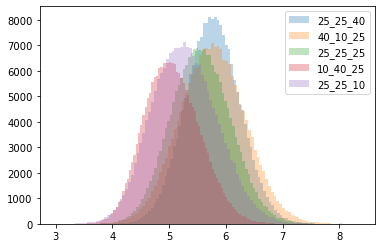

In [175]:
ele_predict = []

# mean_msad = 5.495673167176755
# mean_msad = np.mean(msad_list)
# date = '20221223msad_GNN'
# path_save = f'/media/wz/a7ee6d50-691d-431a-8efb-b93adc04896d/Github/MATools/CE_MC/runs/demo/{date}'
# a_tilt = np.load('/media/wz/7AD631A4D6316195/Projects/SQS_drl/graph/fcc_32/a_tilt.npy')
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# a_tilt = torch.from_numpy(a_tilt).float().to(device)

# fc_ = fc(a_tilt).to(device)
# fc_.load_state_dict(torch.load(path_save+'/gcn4.pth'))
fc_.eval()

compo_mat = [
        [0.25, 0.25, 0.4, 0.1],
        [0.4, 0.1, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25], 
        [0.1, 0.4, 0.25, 0.25],
        [0.25, 0.25, 0.1, 0.4],
]
for compo in compo_mat:
    ele_predict = []
    c1, c2, c3, c4 = compo
    type_ = f'{int(c1*100)}_{int(c2*100)}_{int(c3*100)}'
    for i in range(200000):
        ele_list = ele_list_gen(c1, c2, c3, c4, 32)
        ele_predict.append(ele_list.tolist())

    ele_predict = torch.from_numpy(np.array(ele_predict)).to(device).float()
    predict_msad = fc_(ele_predict).detach().cpu().numpy().flatten()+mean_msad

    print(f'MSAD for {type_} is {np.mean(predict_msad)}')
    plt.hist(predict_msad, bins=100, label=type_, alpha=0.3)

plt.legend()
plt.show()

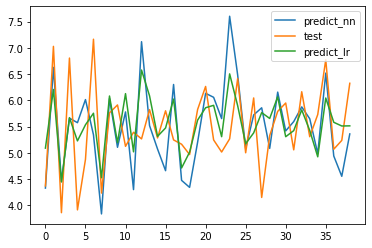

In [73]:
fc_.eval()
energy_std = 1
energy_mean = 0
e_predict = fc_(weight_test).cpu().detach().numpy()
e_test_ = msad_test.cpu().detach().numpy()
e_predict_lr_ = msad_predict_lr

plt.plot(e_predict, label='predict_nn')
plt.plot(e_test_, label='test')
plt.plot(e_predict_lr_, label='predict_lr')

plt.legend()
plt.show()

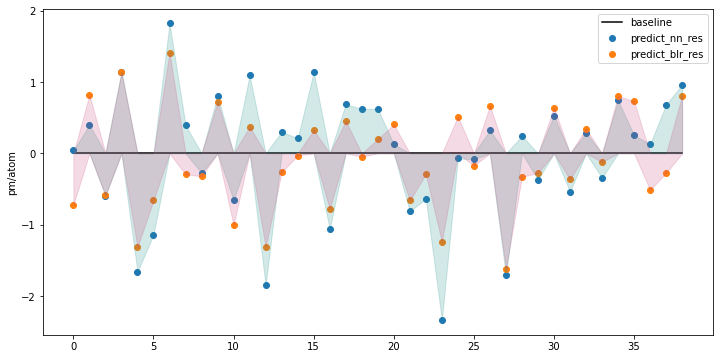

In [74]:
nn_res = (e_test_ - e_predict)
lr_res = (e_test_ - e_predict_lr_.reshape(-1,1))
r_nn_u = np.clip(nn_res, 0, None).flatten()
r_nn_l = np.clip(nn_res, None, 0).flatten()
r_lr_u = np.clip(lr_res, 0, None).flatten()
r_lr_l = np.clip(lr_res, None, 0).flatten()

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_ylabel('pm/atom')
x_axis = np.arange(len(e_test_))
plt.scatter(x_axis, nn_res, label='predict_nn_res')
plt.scatter(x_axis, lr_res, label='predict_blr_res')
plt.plot(x_axis, np.zeros(len(msad_test)), c='k', label='baseline', zorder=0)
plt.fill_between(x_axis, r_nn_l, r_nn_u, 
            alpha=0.2, color=cm.viridis(0.5))
plt.fill_between(x_axis, r_lr_l, r_lr_u, 
            alpha=0.2, color=cm.plasma(0.5))

plt.legend()
plt.show()

In [71]:
###
#* Save NN model
pth_save = '/media/wz/a7ee6d50-691d-431a-8efb-b93adc04896d/Github/MATools/CE_MC/runs/demo/20221031'
torch.save(fc_.state_dict(), pth_save+'/param.pth')

#### SA processes:

1. Starting from **LOCAL MINIMA**

2. Start SA, temperature should gradually increases to ensure the stability of system.

##### Supplementary

1. MC: $$<\alpha> = \frac{\sum\alpha e^{-\beta H_i}}{\sum e^{-\beta H_i}} \tag{1}$$

MD: $$<\alpha>_t = 1/t \sum \alpha(t) \tag{2}$$

2. $T(t) = T_0e^{-t/\tau}$

Text(0.5, 1.0, 'Final temp.: 54.94691666620253 K')

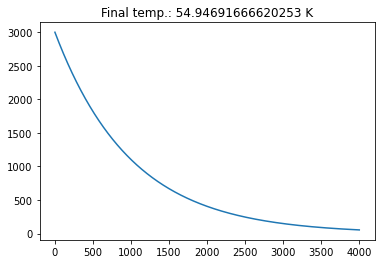

In [16]:
#* Test the setting of temperature decay.
def temp(temp_0, t, tau):
    return temp_0*np.exp(-t/tau)

t = np.linspace(0, 4000, 3001)
temp_ = temp(3000, t, 1000)

plt.plot(t, temp_)
plt.title(f'Final temp.: {temp_[-1]} K')

#### Analysis part for global minimum configuration.

In [14]:
#* Analysis from .py file
import pickle
e_list = np.load('/media/wz/a7ee6d50-691d-431a-8efb-b93adc04896d/Github/MATools/CE_MC/runs/demo/20221101/min_e_.npy')
config_list = np.load('/media/wz/a7ee6d50-691d-431a-8efb-b93adc04896d/Github/MATools/CE_MC/runs/demo/20221101/minconfig_.npy')
lr_model = '/media/wz/a7ee6d50-691d-431a-8efb-b93adc04896d/Github/MATools/CE_MC/runs/demo/20221101/blr.sav'
lr_model_ = pickle.load(open(lr_model, 'rb'))

# lr_model_.predict(config_list)
e_list

array([-15860.06482684, -15861.29076902, -15852.86736414, -15848.19600287,
       -15853.7409672 , -15858.94716383, -15854.62429982, -15852.32496535,
       -15847.70857096, -15853.42011043, -15849.80098587, -15853.33225516])

##### Debugging console for SRO evaluation.

In [9]:
#* Estimation step
#* Use NN?
# fc_.eval()

def norm_w(x, x_mean, x_std):
        return (x - x_mean) / x_std

def t_range(temp_0, t, tau):
    return temp_0*np.exp(-t/tau)

ind_1nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_2048/ind_1nn.npy')
ind_2nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_2048/ind_2nn.npy')
ind_3nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_2048/ind_3nn.npy')
ind_4nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_2048/ind_4nn.npy')
ind_qua1nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_2048/ind_qua1nn.npy')
ind_qua1nn2nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_2048/ind_qua1nn2nn.npy')
ind_trip1nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_2048/ind_trip1nn.npy')
ind_trip1nn2nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_2048/ind_trip1nn2nn.npy')
ind_trip1nn2nn3nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_2048/ind_trip1nn2nn3nn.npy')

ind_1nn_pbc = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_2048/ind_1nn_pbc.npy')
ind_2nn_pbc = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_2048/ind_2nn_pbc.npy')
ind_3nn_pbc = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_2048/ind_3nn_pbc.npy')
ind_4nn_pbc = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_2048/ind_4nn_pbc.npy')
ind_qua1nn_pbc = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_2048/ind_qua1nn_pbc.npy')
# ind_qua1nn2nn_pbc = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_qua1nn2nn_pbc.npy')
ind_trip1nn_pbc = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_2048/ind_trip1nn_pbc.npy')
ind_trip1nn2nn_pbc = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_2048/ind_trip1nn2nn_pbc.npy')
ind_trip1nn2nn3nn_pbc = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_2048/ind_trip1nn2nn3nn_pbc.npy')

ind_raw = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_2048/ind_raw2048.npy')

ce_e = CE(ind_1nn, ind_2nn, ind_3nn, ind_4nn, 
        ind_qua1nn, ind_trip1nn, ind_trip1nn2nn, ind_trip1nn2nn3nn,
        ind_1nn_pbc, ind_2nn_pbc, ind_3nn_pbc, ind_4nn_pbc, 
        ind_qua1nn_pbc, ind_trip1nn_pbc, ind_trip1nn2nn_pbc, ind_trip1nn2nn3nn_pbc,
        ind_raw)

pth_raw = '/media/wz/a7ee6d50-691d-431a-8efb-b93adc04896d/Github/MATools/CE_MC/runs/demo/'

#* Load Classifier
blr_12 = pth_raw+'20221107/blr_12.sav'
blr_23 = pth_raw+'20221107/blr_23.sav'

blr_12 = pickle.load(open(blr_12, 'rb'))
blr_23 = pickle.load(open(blr_23, 'rb'))

#* Load ECI parameters
clf_1 = pth_raw+'20221107/clf_1.sav'
clf_2 = pth_raw+'20221107/clf_2.sav'
clf_3 = pth_raw+'20221107/clf_3.sav'

clf_1 = pickle.load(open(clf_1, 'rb'))
clf_2 = pickle.load(open(clf_2, 'rb'))
clf_3 = pickle.load(open(clf_3, 'rb'))

#* Load tensorboard
date = '20221113'
pth_tb = f'/media/wz/a7ee6d50-691d-431a-8efb-b93adc04896d/Github/MATools/CE_MC/runs/demo/{date}'
writer = SummaryWriter(log_dir = pth_tb)

energy_std, energy_mean = 1, 0

config = ele_list_gen(1/4, 1/4, 1/4, 1/4, num_c=2048)
iter_time= 10000
temp = 1200
k_ = 8.617333262e-5
atom_num = 2048
# energy_std = 1
config_list = np.zeros((50, atom_num))
e_list_store = np.zeros(50)
sro_list_store = np.zeros((iter_time, 12))

for i in range(iter_time):
        # weight_config = norm_w(ce_e.cluster_extra(config).reshape(-1,1).T,
        #                 weight_mean, weight_std)
        config_tile = np.tile(config, 27) #* In 3*3*3 PBC space.
        weight_config  = ce_e.cluster_extra(config_tile).reshape(-1,1).T

        #* Prediction part
        label = int(blr_12.predict(weight_config)[0])
        if label == 0:
                energy = (clf_1.predict(weight_config)*energy_std + energy_mean)[0]
        else:
                label_ = int(blr_23.predict(weight_config)[0])
                if label_ == 0:
                        energy = (clf_2.predict(weight_config)*energy_std + energy_mean)[0]
                else:
                        energy = (clf_3.predict(weight_config)*energy_std + energy_mean)[0]  

        #* NN's prediction
        # weight_config = torch.from_numpy(weight_config.astype(np.float32)).clone().to(device)
        # energy = fc_(weight_config).cpu().detach().numpy()[0,0]*energy_std + energy_mean
        energy *= atom_num
        # e_list.append(energy)
        config_list[i%50] = config
        e_list_store[i%50] = energy
        #* Extract SRO params of current config..
        sro = sub_func_ce.sro_extra(ind_1nn, config, 0.25, 0.25, 0.25, 0.25)
        sro_list_store[i%iter_time] = sro
        
        writer.add_scalar(f'Thermo-MC Energy (eV)', energy, i)
        writer.add_scalar(f'SRO param/CrCr', sro[0], i)
        writer.add_scalar(f'SRO param/MnMn', sro[1], i)
        writer.add_scalar(f'SRO param/CoCo', sro[2], i)
        writer.add_scalar(f'SRO param/NiNi', sro[3], i)
        writer.add_scalar(f'SRO param/CrMn', sro[4], i)
        writer.add_scalar(f'SRO param/CrCo', sro[5], i)
        writer.add_scalar(f'SRO param/CrNi', sro[6], i)
        writer.add_scalar(f'SRO param/MnCo', sro[7], i)
        writer.add_scalar(f'SRO param/MnNi', sro[8], i)
        writer.add_scalar(f'SRO param/CoNi', sro[9], i)

        while True:
                a_ind = randrange(len(ind_1nn))
                action = ind_1nn[a_ind]
                a1, a2 = config[action[0]], config[action[1]]
                if a1 != a2:
                        break

        config_ = swap_step(action, config)

        assert np.linalg.norm(np.sort(config_)-np.sort(config)) == 0, print(f'BUG in swap_step')
        # weight_config_ = norm_w(ce_e.cluster_extra(config_).reshape(-1,1).T,
        #                 weight_mean, weight_std)
        config_tile_ = np.tile(config_, 27) #* In 3*3*3 PBC space.
        weight_config_ = ce_e.cluster_extra(config_tile_).reshape(-1,1).T
        #* NN's prediction
        # weight_config_ = torch.from_numpy(weight_config_.astype(np.float32)).clone().to(device)
        # energy_ = fc_(weight_config_).cpu().detach().numpy()[0,0]*energy_std + energy_mean
        #* Prediction part
        label = int(blr_12.predict(weight_config_)[0])
        if label == 0:
                energy_ = (clf_1.predict(weight_config_)*energy_std + energy_mean)[0]
        else:
                label_ = int(blr_23.predict(weight_config_)[0])
                if label_ == 0:
                        energy_ = (clf_2.predict(weight_config_)*energy_std + energy_mean)[0]
                else:
                        energy_ = (clf_3.predict(weight_config_)*energy_std + energy_mean)[0] 

        energy_ *= atom_num

        accept = np.min([1, np.exp((energy-energy_)/(k_*temp))])
        r_v = np.random.rand()
        if r_v <= accept:
                config = config_
        else:
                config = config

        clear_output(True)
        # plt.title(f'Iter num {i} at {temp} K')
        # plt.plot(e_list)
        # plt.show()

In [2]:
config = ele_list_gen(1/4, 1/4, 1/4, 1/4, num_c=2048)
ind_1nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_2048/ind_1nn.npy')
sub_func_ce.sro_extra(ind_1nn, config, 0.25, 0.25, 0.25, 0.25)

array([ 5.01481481e-01,  5.02962963e-01,  4.88148148e-01,  5.00000000e-01,
        1.40740741e-02, -1.40740741e-02,  2.22222222e-03, -7.40740741e-04,
        4.44444444e-03,  1.48148148e-03,  1.08000000e+04,  1.08000000e+04])

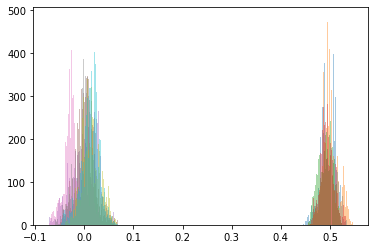

In [11]:
%matplotlib inline
from fitter import Fitter
#* Check the distribution of energy
for i in range(sro_list_store.shape[1]-2):
    sro = sro_list_store[:,i]
    plt.hist(sro, bins=100, alpha=0.4)

plt.show()
# f_pair = Fitter(mncr_list, distributions = ['norm'], timeout = 1500)
# f_pair.fit()

# print(f_pair.get_best())
# f_pair.summary()

In [10]:
np.save('/media/wz/a7ee6d50-691d-431a-8efb-b93adc04896d/Github/MATools/CE_MC/runs/demo/20221107/sro_1200.npy', sro_list_store)

In [12]:
# sro_100 = np.load('/media/wz/a7ee6d50-691d-431a-8efb-b93adc04896d/Github/MATools/CE_MC/runs/demo/20221107/sro_100.npy')
sro_400 = np.load('/media/wz/a7ee6d50-691d-431a-8efb-b93adc04896d/Github/MATools/CE_MC/runs/demo/20221107/sro_400.npy')
sro_1200 = np.load('/media/wz/a7ee6d50-691d-431a-8efb-b93adc04896d/Github/MATools/CE_MC/runs/demo/20221107/sro_1200.npy')
# sro_4000 = np.load('/media/wz/a7ee6d50-691d-431a-8efb-b93adc04896d/Github/MATools/CE_MC/runs/demo/20221107/sro_4000.npy')

# sro_100_mean = np.mean(sro_100[1000:], 0).reshape(-1,1)
sro_400_mean = np.mean(sro_400[1000:], 0).reshape(-1,1)
sro_1200_mean = np.mean(sro_1200[1000:], 0).reshape(-1,1)
# sro_4000_mean = np.mean(sro_4000[1000:], 0).reshape(-1,1)

sro_mean = np.concatenate([sro_400_mean, sro_1200_mean], 1)

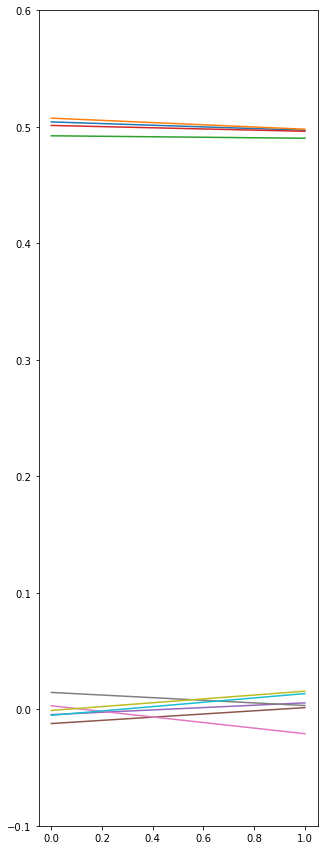

In [18]:
fig, ax = plt.subplots(figsize=(5, 15))

for i in range(len(sro_400_mean)-2):
    plt.plot(sro_mean[i])

plt.ylim([-0.1, 0.6])
plt.show()

#### Analyzing CE estimations

Results are following an order of 

a_crcr, a_mnmn, a_coco, a_nini, a_mncr, a_cocr, a_nicr, a_comn, a_nimn, a_nico

In [18]:
sro_name = ['a_crcr', 'a_mnmn', 'a_coco', 'a_nini', 'a_mncr', 'a_cocr', 'a_nicr', 'a_comn', 'a_nimn', 'a_nico']
temp_range = np.array([100, 200, 300, 400, 500, 800, 1000, 1200, 1600, 2400, 3200, 4800])
sro_list = np.zeros((len(temp_range), 10)) #* Nx10
pth_raw = '/media/wz/a7ee6d50-691d-431a-8efb-b93adc04896d/Github/MATools/CE_MC/runs/demo/20221101/'
for i in range(len(temp_range)):
    sro_list[i] = np.mean(np.load(pth_raw+f'sro_{temp_range[i]}.npy'), axis=0)

sro_list.shape

(12, 10)

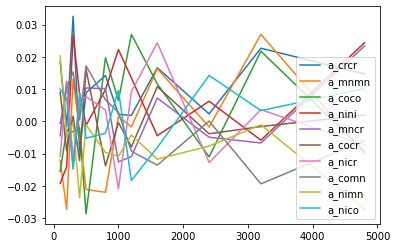

In [20]:
for i in range(10):
    plt.plot(temp_range, sro_list[:, i], label=sro_name[i])

plt.legend()
plt.show()